## 0) Import and Function Definitions

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
import matplotlib.animation as manim
from skimage.measure import find_contours
from tqdm import tqdm

import pylidc as pl
from pylidc.utils import consensus

print(pl.__version__)

0.2.3


In [20]:
def resample_volume(scan, new_spacing=[1.0, 1.0, 1.0], pad=32):
    # Convert pylidc Scan object to SimpleITK Image
    sitk_image = sitk.GetImageFromArray(scan.to_volume())
    sitk_image.SetSpacing([scan.slice_thickness, scan.pixel_spacing, scan.pixel_spacing])

    original_spacing = np.array(sitk_image.GetSpacing())
    original_size = np.array(sitk_image.GetSize())
    
    print(f"Original spacing: {original_spacing}, Original size: {original_size}")
    
    # Calculate new size to preserve volume of the original image
    new_size = original_size * (original_spacing / new_spacing)
    new_size = np.ceil(new_size).astype(int).tolist()  # SimpleITK expects lists of ints
    print(f"New size: {new_size}")
    new_size = [32, 32, 32]
    
    # Resampling the image
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetSize(new_size)
    resample.SetOutputSpacing(new_spacing)
    
    # New origin is adjusted to keep the center of the image the same
    new_origin = np.array(sitk_image.GetOrigin()) - original_spacing + new_spacing
    resample.SetOutputOrigin(new_origin.tolist())
    
    # Perform the resampling
    new_image = resample.Execute(sitk_image)
    return sitk.GetArrayFromImage(new_image)

# Resample the volume
scans = pl.query(pl.Scan).all()
scan = scans[2]
vol = scan.to_volume()
print(f"Original volume shape: {vol.shape}")
print(f"Original volume spacing: {scan.pixel_spacing, scan.pixel_spacing, scan.slice_thickness}")
resampled_vol = resample_volume(scan, [1.0, 1.0, 1.0])
print(f"Resampled volume shape: {resampled_vol.shape}")


Loading dicom files ... This may take a moment.
Original volume shape: (512, 512, 113)
Original volume spacing: (0.698, 0.698, 3.0)
Loading dicom files ... This may take a moment.
Original spacing: [3.    0.698 0.698], Original size: [113 512 512]
New size: [339, 358, 358]
Resampled volume shape: (32, 32, 32)


In [56]:
def resample_volume(scan, bbox, mask, new_spacing=[1.0, 1.0, 1.0], pad=32):
    # Convert pylidc Scan object to SimpleITK Image
    sitk_image = sitk.GetImageFromArray(scan.to_volume()[bbox])
    sitk_image.SetSpacing([scan.slice_thickness, scan.pixel_spacing, scan.pixel_spacing])
    
    original_spacing = np.array(sitk_image.GetSpacing())
    original_size = np.array(sitk_image.GetSize())
    
    print(f"Original spacing: {original_spacing}, Original size: {original_size}")
    
    # Calculate new size to preserve volume of the original image
    new_size = original_size * (original_spacing / new_spacing)
    new_size = np.ceil(new_size).astype(int).tolist()  # SimpleITK expects lists of ints
    
    new_size = [32, 32, 32]
    print(f"New spacing: {new_spacing}", f"New size: {new_size}")
    
    
    # Resampling the image
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetSize(new_size)
    # resample.SetOutputSpacing(new_spacing)
    
    # New origin is adjusted to keep the center of the image the same
    # new_origin = np.array(sitk_image.GetOrigin()) - original_spacing + new_spacing
    # resample.SetOutputOrigin(new_origin.tolist())
    
    # Perform the resampling
    new_image = resample.Execute(sitk_image)
    return sitk.GetArrayFromImage(new_image)

Loading dicom files ... This may take a moment.
Scan volume shape: (512, 512, 113)
Processing nodule 1 of 1: LIDC-IDRI-0079-1
Found 4 annotations.
Volume shape: (87, 82, 65), Mask shape: (87, 82, 65)
Loading dicom files ... This may take a moment.
Original spacing: [3.    0.698 0.698], Original size: [65 82 87]
New spacing: [1.0, 1.0, 1.0] New size: [32, 32, 32]
Resampled volume shape: (32, 32, 32)


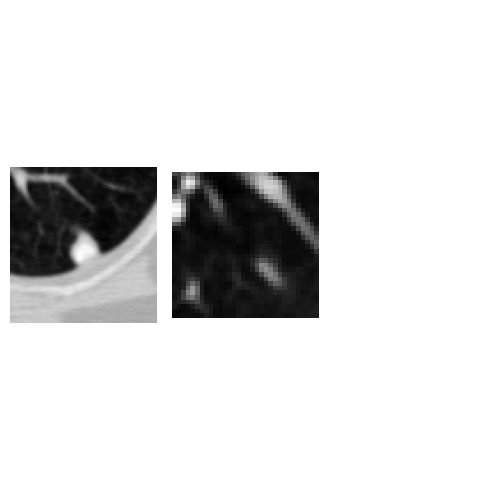

In [57]:
scan = scans[2]
print(f"Scan volume shape: {scan.to_volume().shape}")
nodules = scan.cluster_annotations()
for nod_idx,nod in enumerate(nodules):
    print("="*75)
    print(f"Processing nodule {nod_idx+1} of {len(nodules)}: {nod[0].scan.patient_id+'-'+str(nod_idx+1)}")
    print(f"Found {len(nod)} annotations.")
    print("="*75)
    
    # Perform a consensus consolidation and 50% agreement level.
    cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=30)
    print(f"Volume shape: {vol[cbbox].shape}, Mask shape: {cmask.shape}")
    resampled_vol = resample_volume(scan, bbox=cbbox, mask=cmask, new_spacing=[1.0, 1.0, 1.0], pad=32)
    print(f"Resampled volume shape: {resampled_vol.shape}")
    
    fig,ax = plt.subplots(1,3,figsize=(5,5))
    ax[0].imshow(vol[cbbox][:,:,32], cmap=plt.cm.gray)
    ax[1].imshow(resampled_vol[:,:,16], cmap=plt.cm.gray)
    
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.tight_layout()
    plt.show()
    

In [79]:
MIN_BOUND = -1000.0
# MIN_BOUND = -1500.0
MAX_BOUND = 200.0
# MAX_BOUND = 1200.0
PIXEL_MEAN = 0.25

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>(1-PIXEL_MEAN)] = 1.
    image[image<(0-PIXEL_MEAN)] = 0.
    return np.array(255 * image, dtype="uint8")

def normalize(image):
    image[image>MAX_BOUND] = MAX_BOUND
    image[image<MIN_BOUND] = MIN_BOUND
    return image

## Visualise Database

In [19]:
scans = pl.query(pl.Scan).limit(5)
# anns = pl.query(pl.Annotation).limit(5)

print(f"Found {scans.count()} scans")
# print(f"Found {anns.count()} annotations.")

print("Loading scans...")
ann_count = 0
for i,scan in enumerate(scans):
    ann_count += len(scan.annotations)
    
print(f"Found {ann_count} annotations in {scans.count()} scans.")


Found 5 scans
Loading scans...
Found 34 annotations in 5 scans.


################################################################################
Processing scan 1 of 5: LIDC-IDRI-0078
Found 13 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Volume shape: (512, 512, 87)
Processing nodule 1 of 4: LIDC-IDRI-0078-1
Found 4 annotations.
Volume shape: (94, 104, 59)


<Figure size 640x480 with 0 Axes>

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 19.50 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [4 1 6 4 4 1 2 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


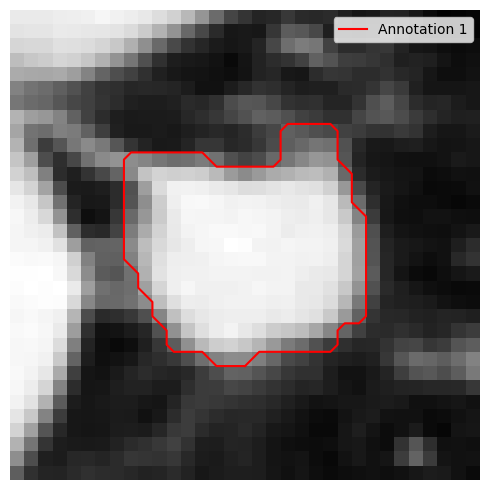

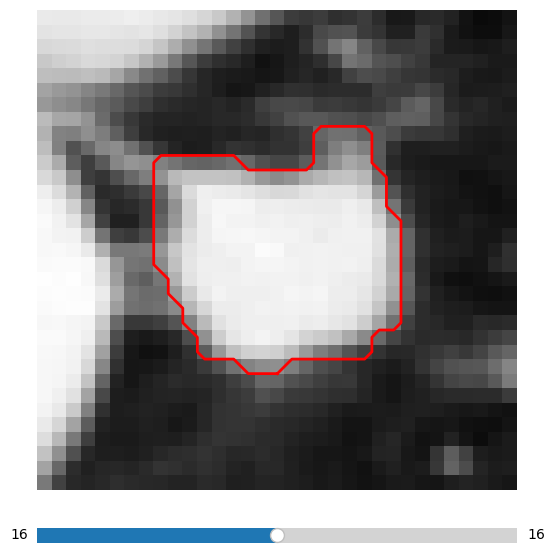

----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 27.65 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Nearly No Lobulation     | 2 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Moderately Suspicious    | 4 
Feature NunPy Array: [4 1 6 4 2 2 1 5 4]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


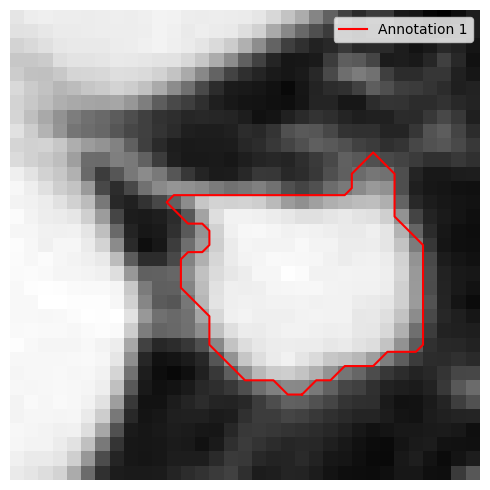

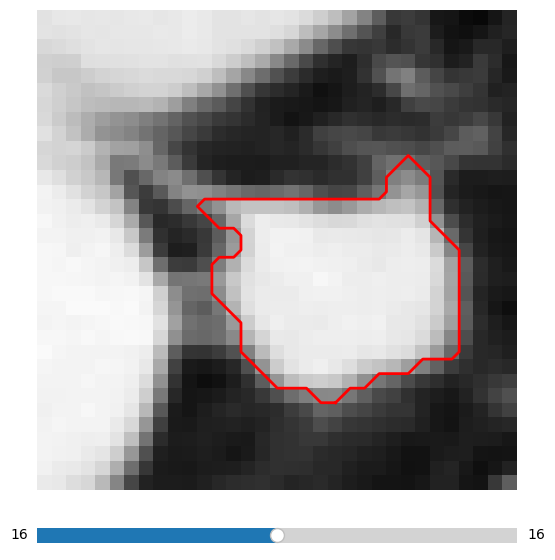

----------------------------------------------------------------------
Processing annotation 3 of 4
----------------------------------------------------------------------
Diameter: 27.98 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | Near Marked Spiculation  | 4 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [5 1 6 4 4 4 4 5 5]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


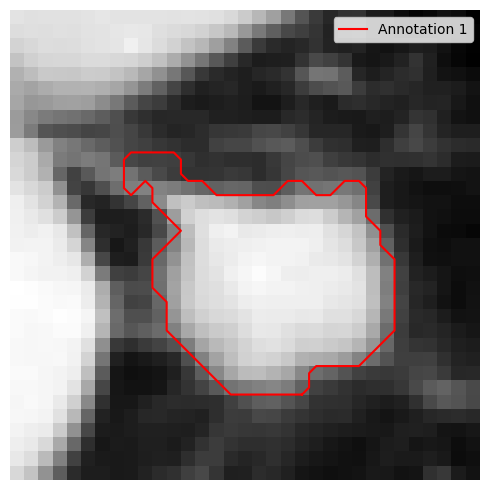

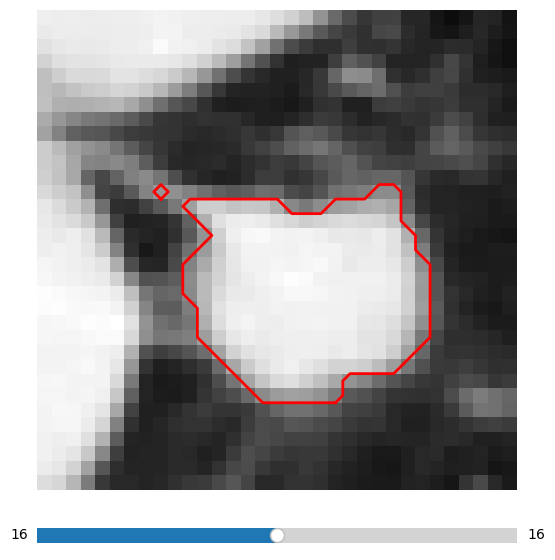

----------------------------------------------------------------------
Processing annotation 4 of 4
----------------------------------------------------------------------
Diameter: 20.65 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Medium Margin            | 3 
Lobulation         | Nearly No Lobulation     | 2 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid/Mixed              | 4 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 4 3 2 2 4 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


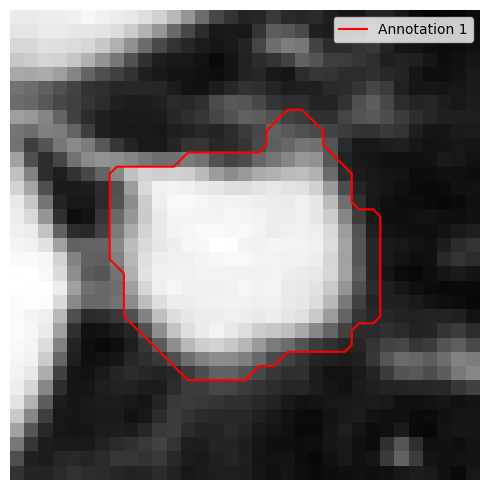

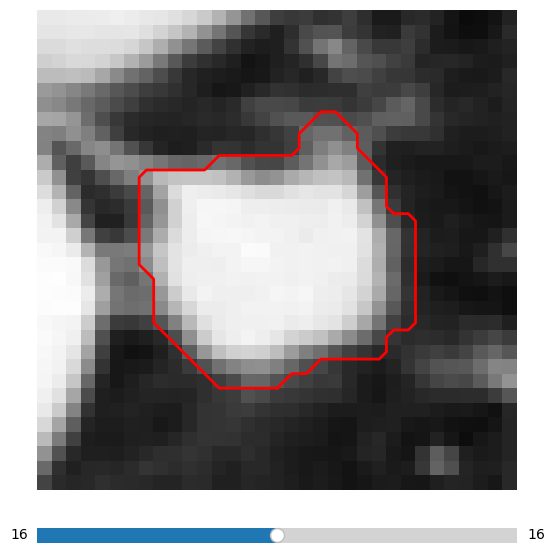

Processing nodule 2 of 4: LIDC-IDRI-0078-2
Found 4 annotations.
Volume shape: (0, 0, 19)


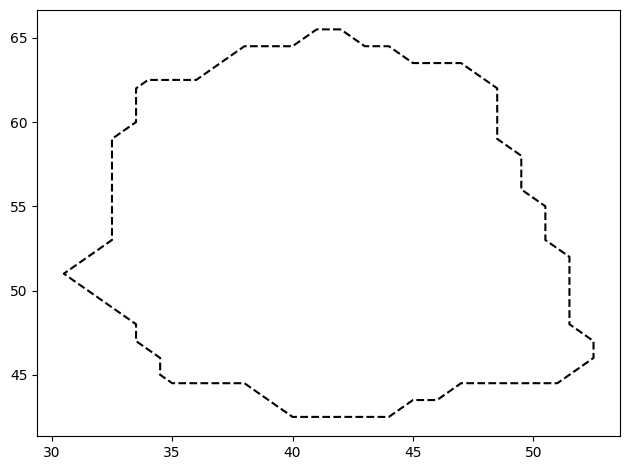

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 20.84 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 3 4 1 1 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


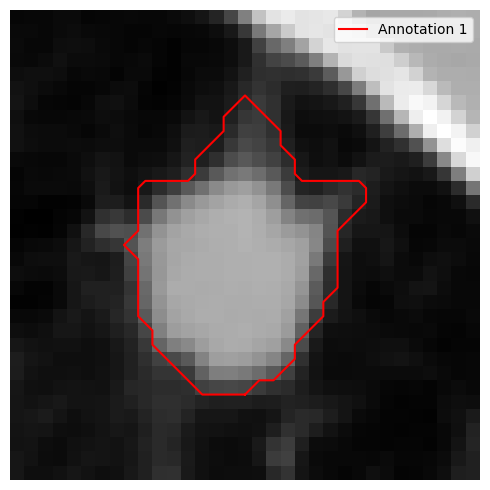

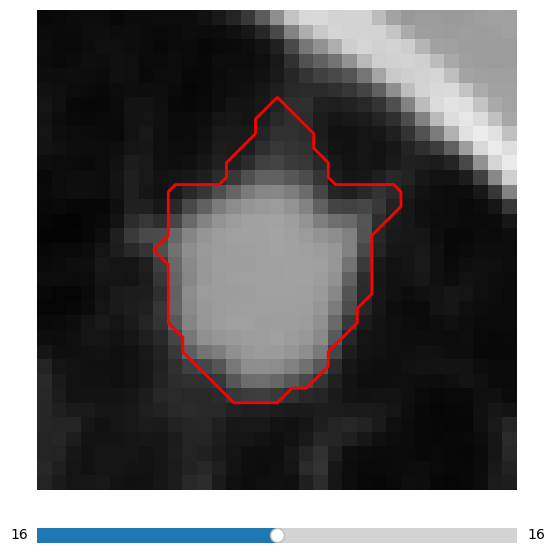

----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 20.89 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Medium Lobulation        | 3 
Spiculation        | No Spiculation           | 1 
Texture            | Solid/Mixed              | 4 
Malignancy         | Moderately Suspicious    | 4 
Feature NunPy Array: [4 1 6 4 2 3 1 4 4]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


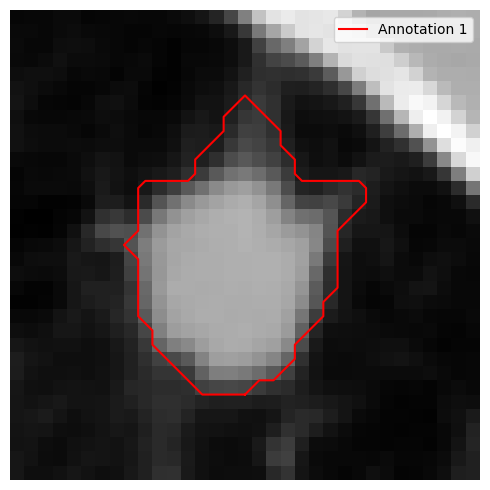

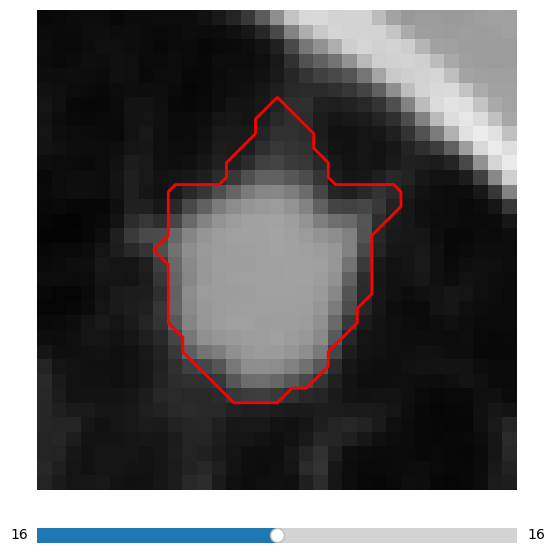

----------------------------------------------------------------------
Processing annotation 3 of 4
----------------------------------------------------------------------
Diameter: 23.54 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Round                    | 5 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | Medium Spiculation       | 3 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [5 1 6 5 2 4 3 5 5]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


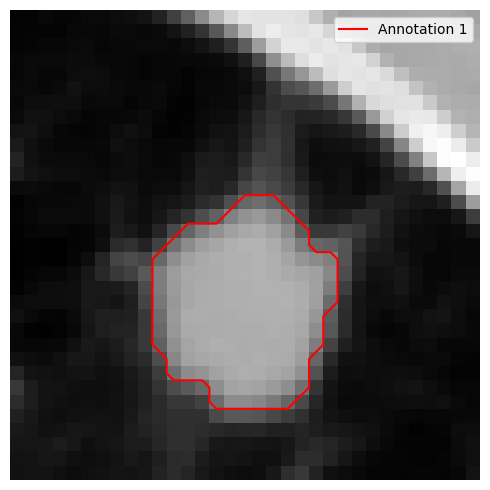

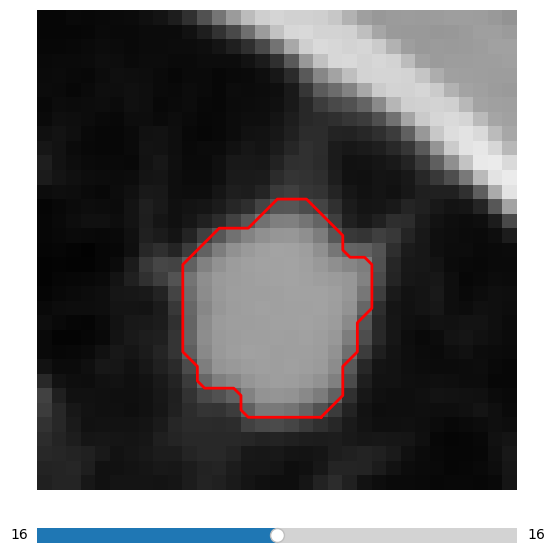

----------------------------------------------------------------------
Processing annotation 4 of 4
----------------------------------------------------------------------
Diameter: 17.50 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Medium Margin            | 3 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | Near Marked Spiculation  | 4 
Texture            | Solid/Mixed              | 4 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 4 3 4 4 4 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


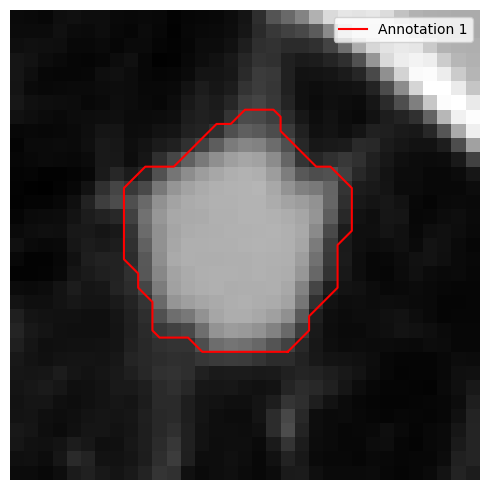

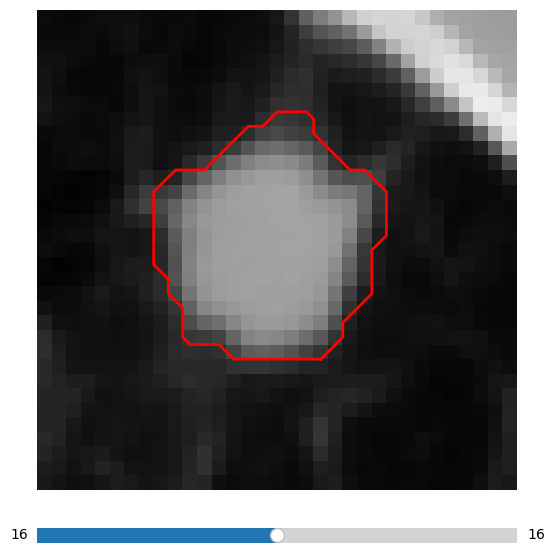

Processing nodule 3 of 4: LIDC-IDRI-0078-3
Found 1 annotations.
Processing nodule 4 of 4: LIDC-IDRI-0078-4
Found 4 annotations.
Volume shape: (0, 0, 0)


<Figure size 640x480 with 0 Axes>

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 23.30 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Non-central              | 4 
Sphericity         | Ovoid                    | 3 
Margin             | Sharp                    | 5 
Lobulation         | Nearly No Lobulation     | 2 
Spiculation        | Medium Spiculation       | 3 
Texture            | Solid                    | 5 
Malignancy         | Moderately Suspicious    | 4 
Feature NunPy Array: [5 1 4 3 5 2 3 5 4]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


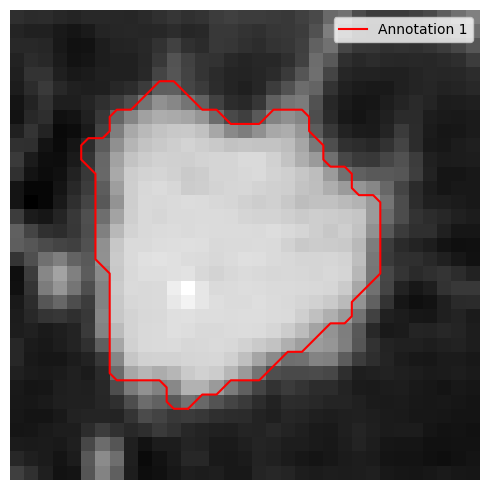

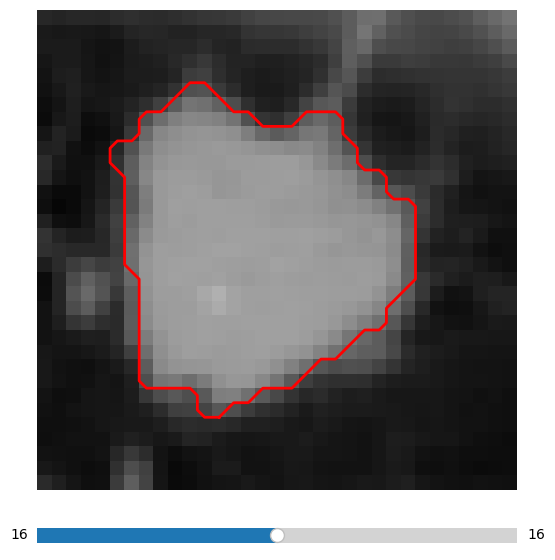

----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 32.81 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [5 1 6 4 2 4 1 5 5]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


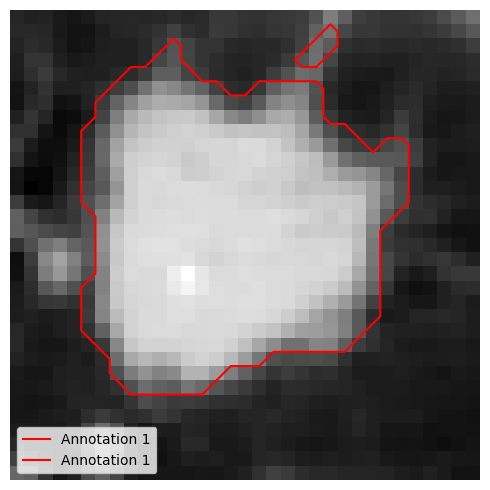

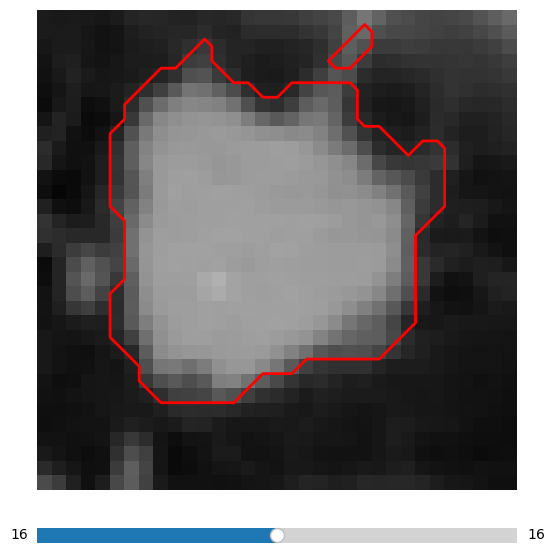

----------------------------------------------------------------------
Processing annotation 3 of 4
----------------------------------------------------------------------
Diameter: 28.67 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Non-central              | 4 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | Near Marked Spiculation  | 4 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [5 1 4 4 4 4 4 5 5]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


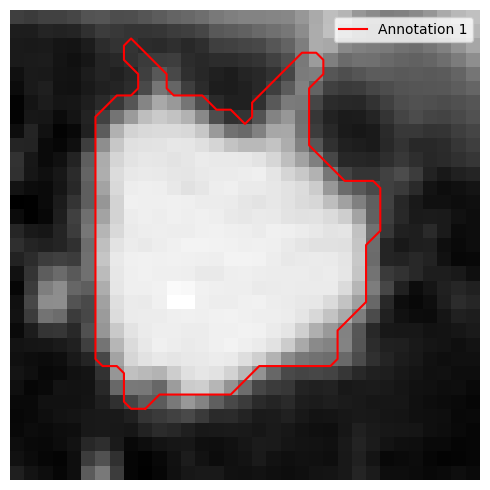

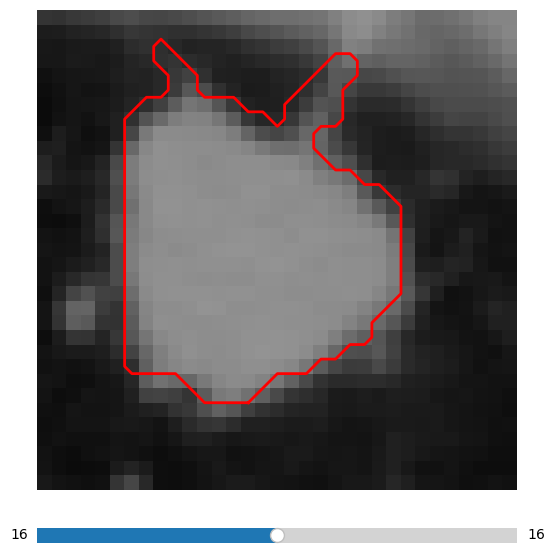

----------------------------------------------------------------------
Processing annotation 4 of 4
----------------------------------------------------------------------
Diameter: 26.00 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Medium Lobulation        | 3 
Spiculation        | Medium Spiculation       | 3 
Texture            | Solid/Mixed              | 4 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 4 2 3 3 4 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


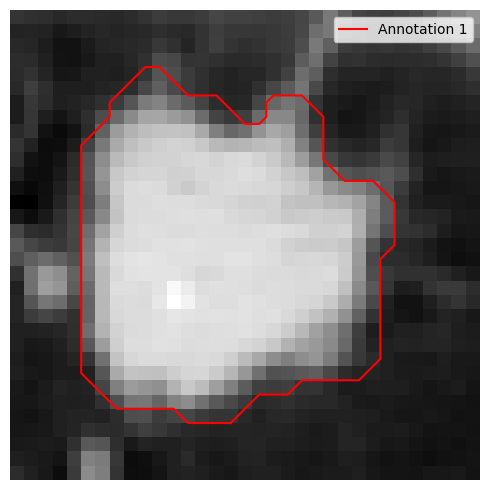

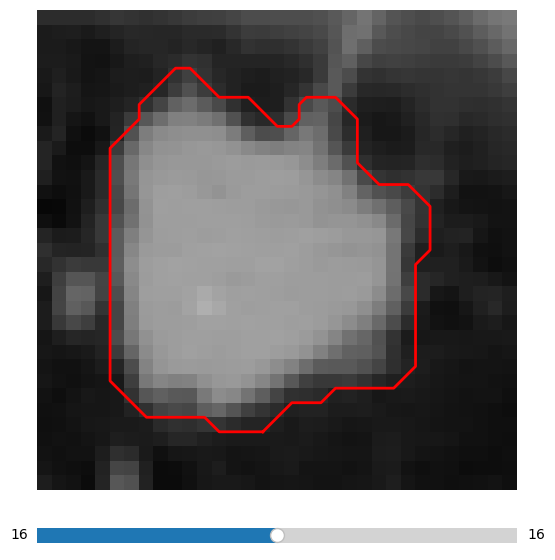

################################################################################
Processing scan 2 of 5: LIDC-IDRI-0069
Found 9 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Volume shape: (512, 512, 136)
Processing nodule 1 of 3: LIDC-IDRI-0069-1
Found 4 annotations.
Volume shape: (86, 79, 69)


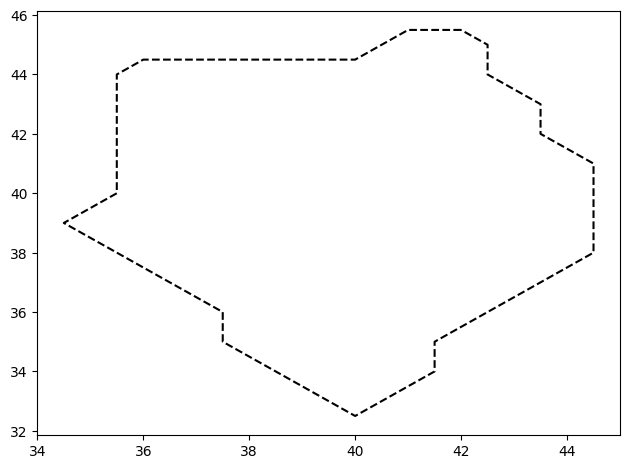

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 12.68 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Fairly Subtle            | 3 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Round                    | 5 
Margin             | Sharp                    | 5 
Lobulation         | Marked Lobulation        | 5 
Spiculation        | Marked Spiculation       | 5 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [3 1 6 5 5 5 5 5 5]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


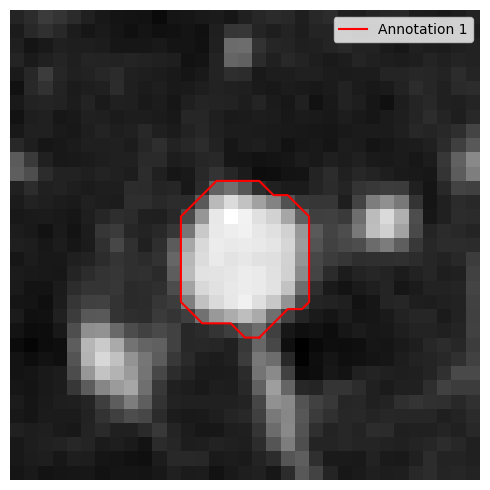

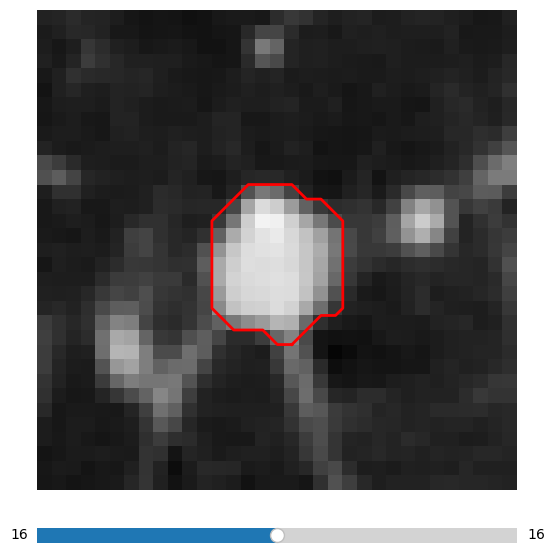

----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 10.40 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Subtle        | 2 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | Nearly No Lobulation     | 2 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Moderately Unlikely      | 2 
Feature NunPy Array: [2 1 6 4 4 2 1 5 2]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


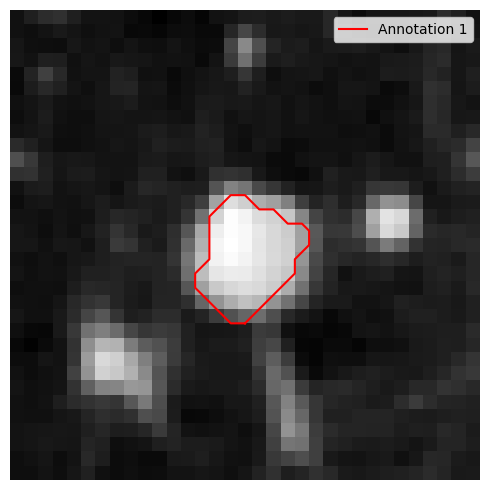

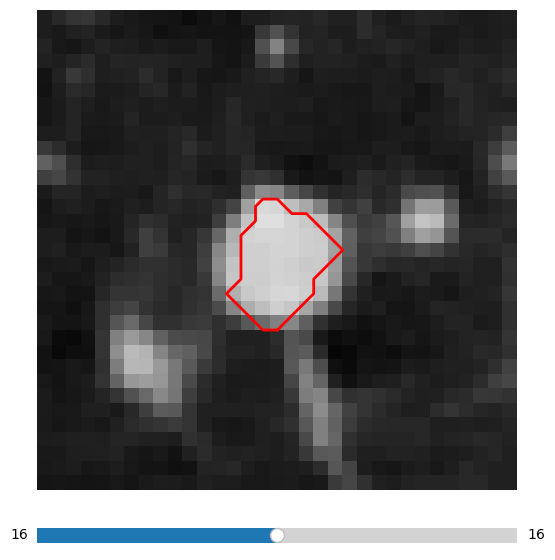

----------------------------------------------------------------------
Processing annotation 3 of 4
----------------------------------------------------------------------
Diameter: 18.23 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Subtle        | 2 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Sharp                    | 5 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | Marked Spiculation       | 5 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [2 1 6 4 5 4 5 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


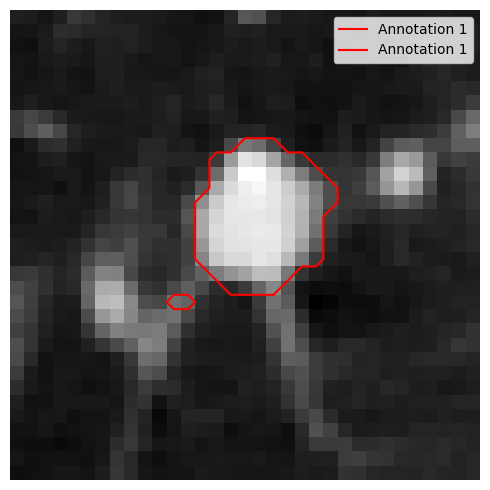

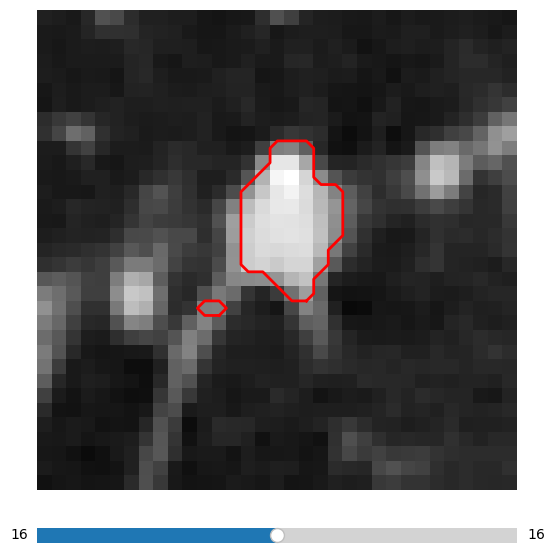

----------------------------------------------------------------------
Processing annotation 4 of 4
----------------------------------------------------------------------
Diameter: 9.28 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Fairly Subtle            | 3 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Round                    | 5 
Margin             | Medium Margin            | 3 
Lobulation         | Marked Lobulation        | 5 
Spiculation        | Marked Spiculation       | 5 
Texture            | Solid/Mixed              | 4 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [3 1 6 5 3 5 5 4 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


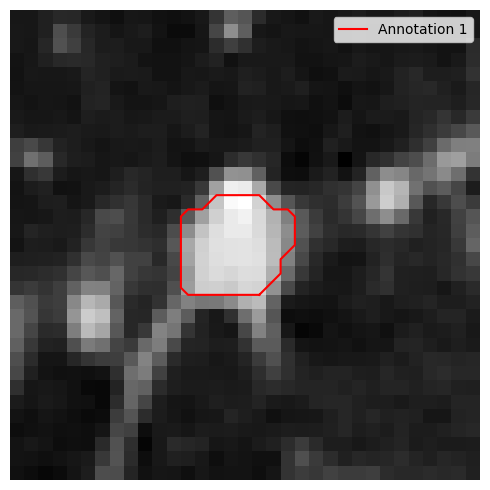

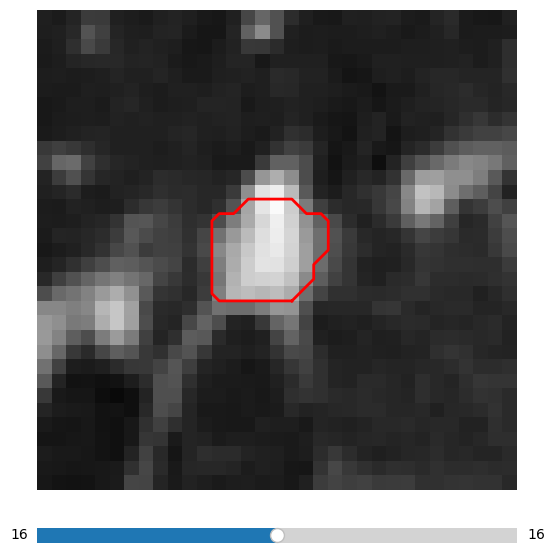

Processing nodule 2 of 3: LIDC-IDRI-0069-2
Found 1 annotations.
Processing nodule 3 of 3: LIDC-IDRI-0069-3
Found 4 annotations.
Volume shape: (0, 0, 0)


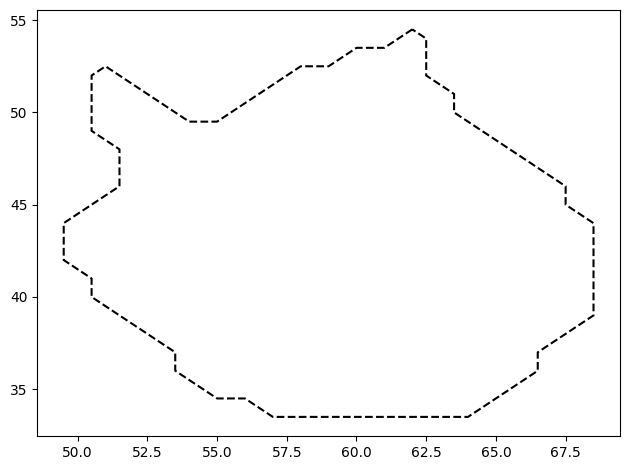

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 23.92 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Sharp                    | 5 
Lobulation         | Marked Lobulation        | 5 
Spiculation        | Near Marked Spiculation  | 4 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [5 1 6 4 5 5 4 5 5]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


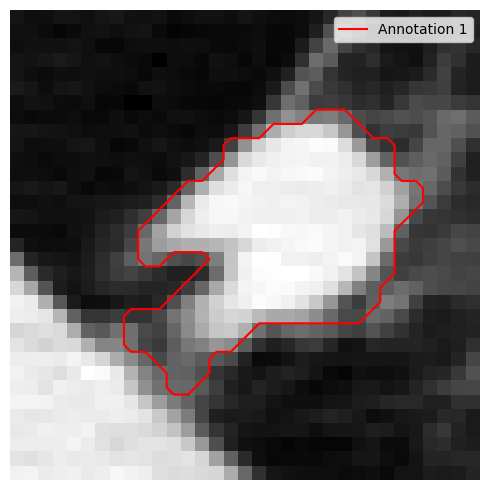

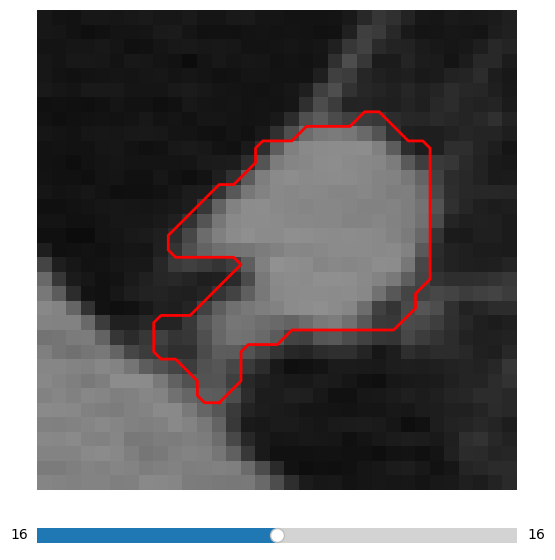

----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 24.27 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Medium Margin            | 3 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [4 1 6 3 3 4 2 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


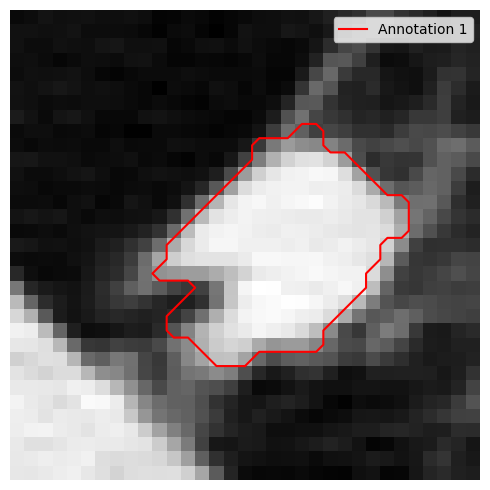

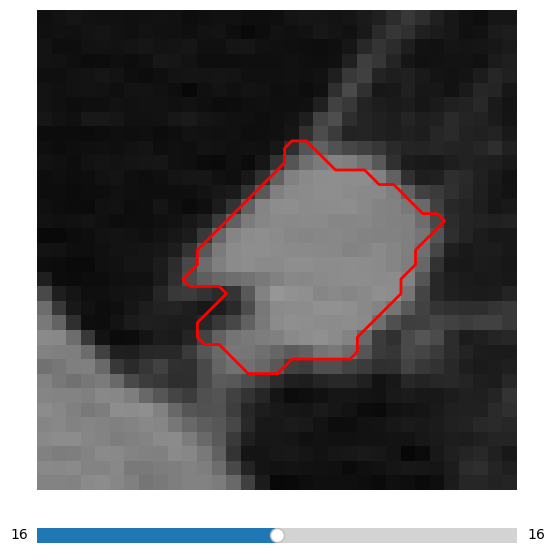

----------------------------------------------------------------------
Processing annotation 3 of 4
----------------------------------------------------------------------
Diameter: 24.37 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Medium Margin            | 3 
Lobulation         | Marked Lobulation        | 5 
Spiculation        | Medium Spiculation       | 3 
Texture            | Solid                    | 5 
Malignancy         | Moderately Suspicious    | 4 
Feature NunPy Array: [5 1 6 4 3 5 3 5 4]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


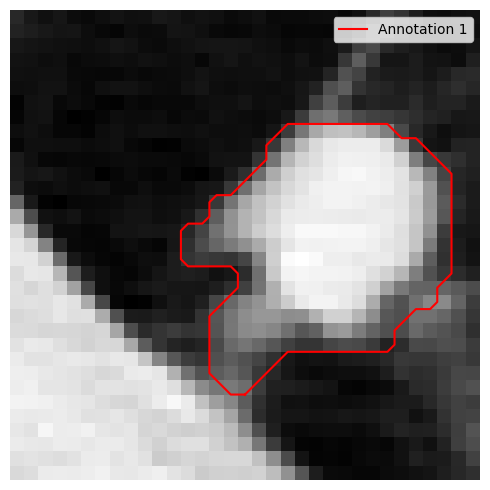

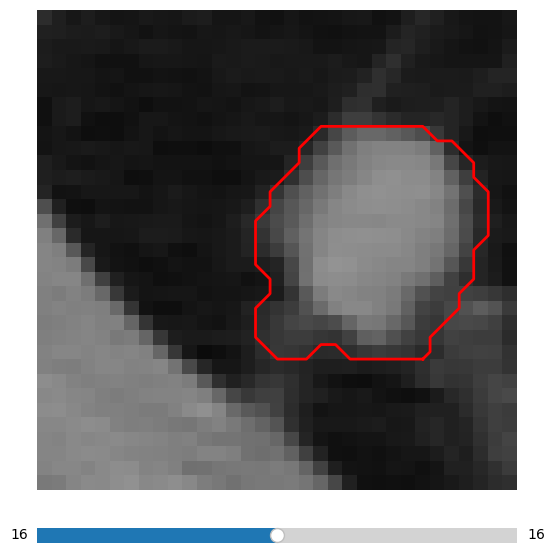

----------------------------------------------------------------------
Processing annotation 4 of 4
----------------------------------------------------------------------
Diameter: 24.63 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Medium Margin            | 3 
Lobulation         | Medium Lobulation        | 3 
Spiculation        | Marked Spiculation       | 5 
Texture            | Solid/Mixed              | 4 
Malignancy         | Moderately Unlikely      | 2 
Feature NunPy Array: [5 1 6 4 3 3 5 4 2]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


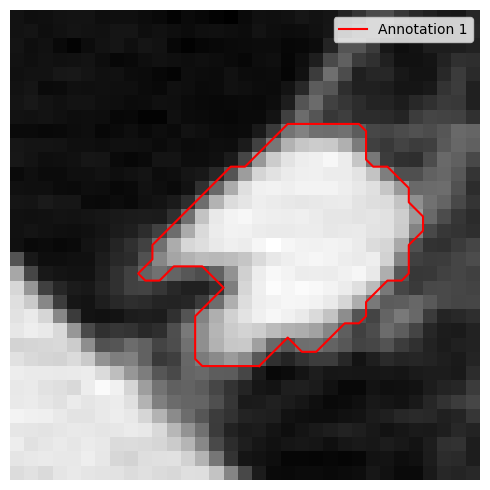

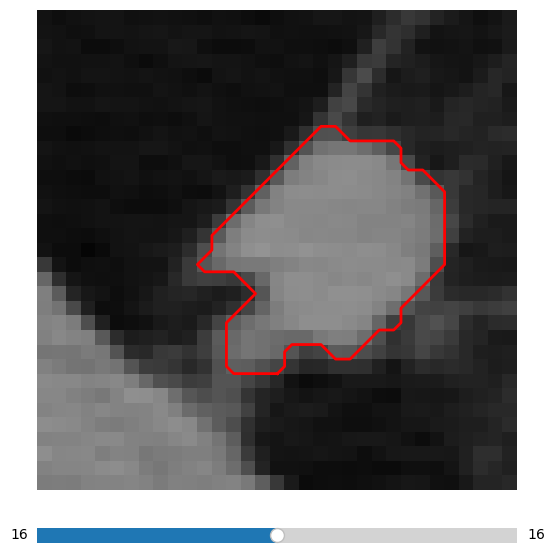

################################################################################
Processing scan 3 of 5: LIDC-IDRI-0079
Found 4 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Volume shape: (512, 512, 113)
Processing nodule 1 of 1: LIDC-IDRI-0079-1
Found 4 annotations.
Volume shape: (87, 82, 65)


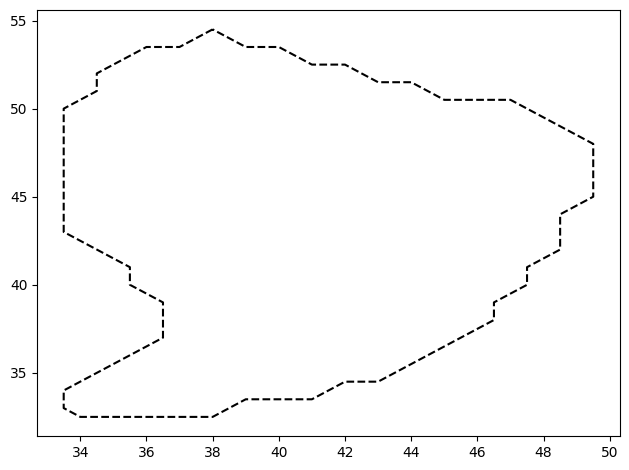

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 17.11 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Fairly Subtle            | 3 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Medium Margin            | 3 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [3 1 6 3 3 1 1 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


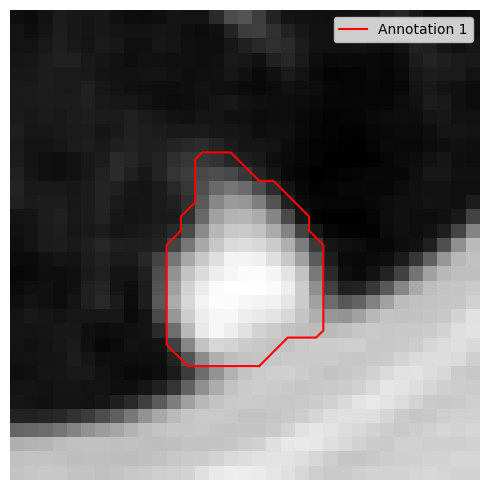

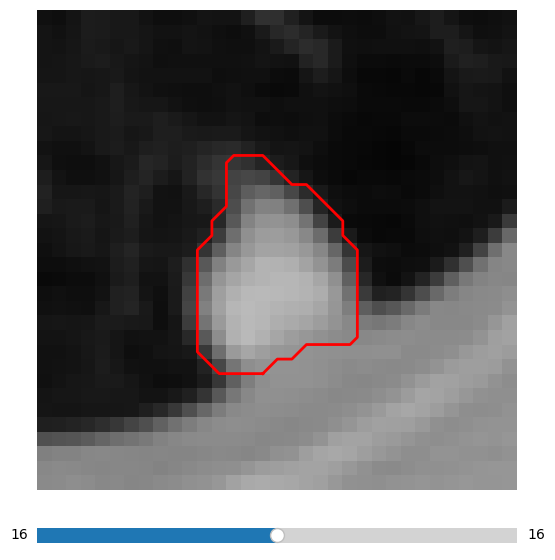

----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 16.47 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | Medium Lobulation        | 3 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 4 4 3 1 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


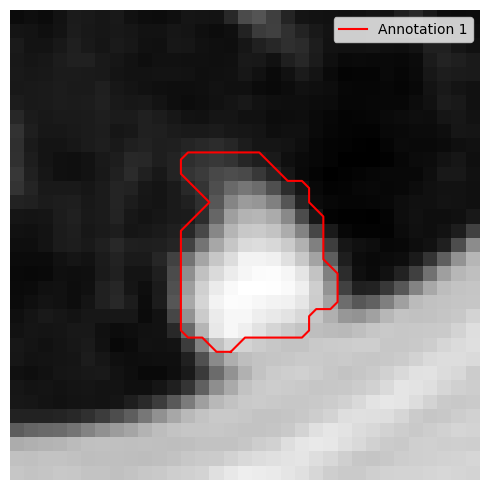

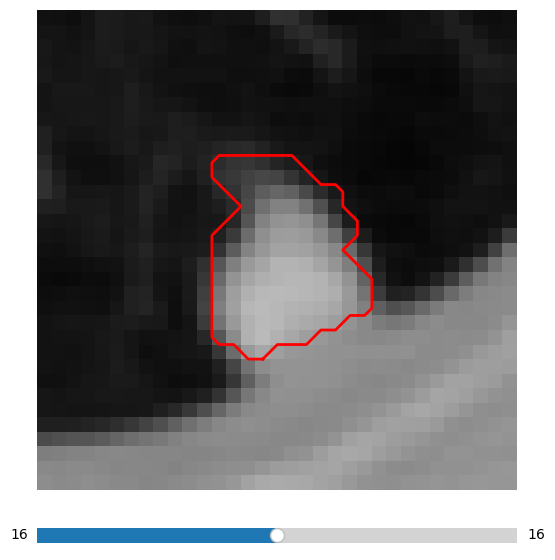

----------------------------------------------------------------------
Processing annotation 3 of 4
----------------------------------------------------------------------
Diameter: 13.71 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Central                  | 5 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | Medium Lobulation        | 3 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid                    | 5 
Malignancy         | Highly Unlikely          | 1 
Feature NunPy Array: [5 1 5 4 4 3 2 5 1]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


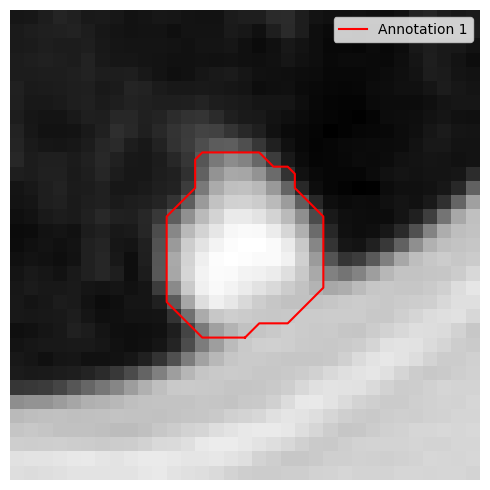

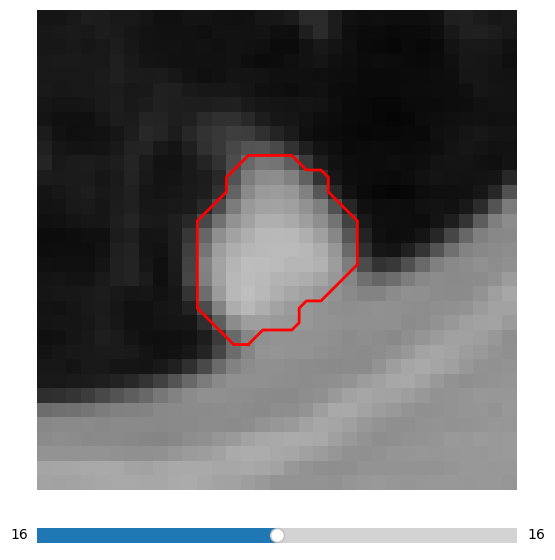

----------------------------------------------------------------------
Processing annotation 4 of 4
----------------------------------------------------------------------
Diameter: 17.28 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | Nearly No Lobulation     | 2 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid/Mixed              | 4 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 4 4 2 2 4 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


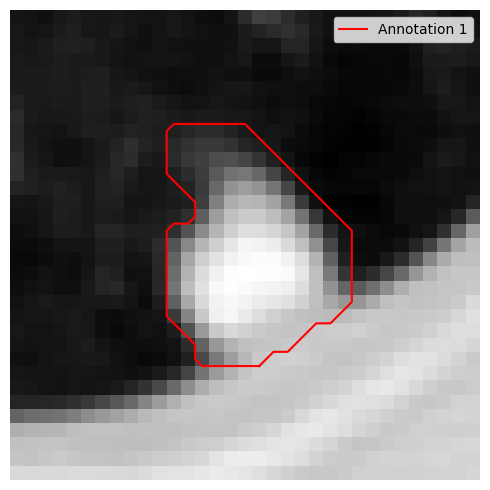

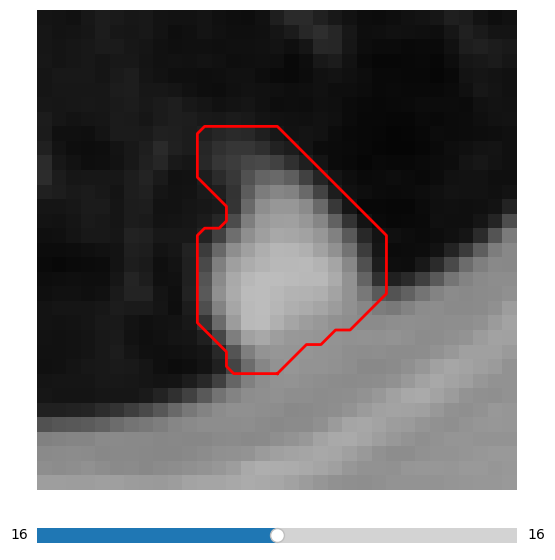

################################################################################
Processing scan 4 of 5: LIDC-IDRI-0101
Found 2 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Volume shape: (512, 512, 150)
Processing nodule 1 of 1: LIDC-IDRI-0101-1
Found 2 annotations.
################################################################################
Processing scan 5 of 5: LIDC-IDRI-0110
Found 6 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Volume shape: (512, 512, 125)
Processing nodule 1 of 2: LIDC-IDRI-0110-1
Found 3 annotations.
Volume shape: (77, 77, 64)


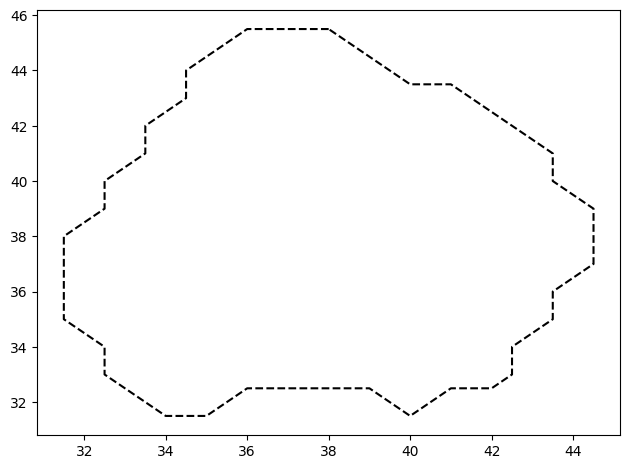

----------------------------------------------------------------------
Processing annotation 1 of 3
----------------------------------------------------------------------
Diameter: 11.55 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Round                    | 5 
Margin             | Medium Margin            | 3 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 5 3 1 1 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


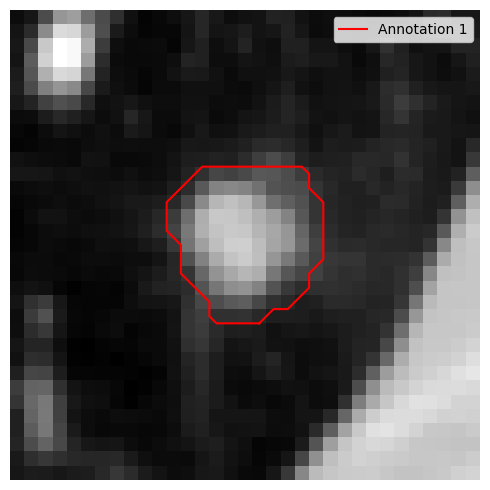

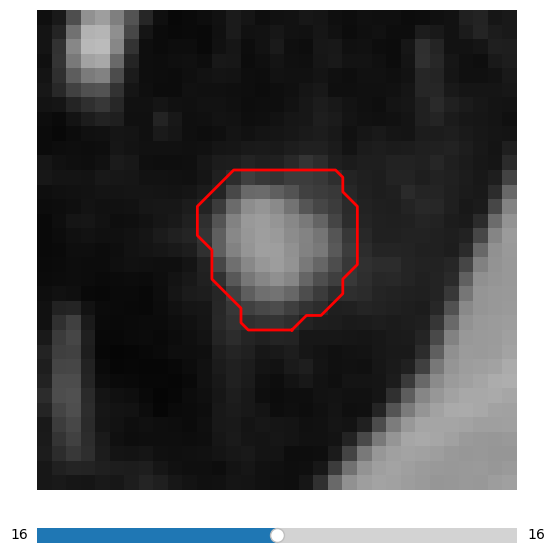

----------------------------------------------------------------------
Processing annotation 2 of 3
----------------------------------------------------------------------
Diameter: 10.17 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Round                    | 5 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | Medium Spiculation       | 3 
Texture            | Part Solid/Mixed         | 3 
Malignancy         | Moderately Suspicious    | 4 
Feature NunPy Array: [4 1 6 5 2 4 3 3 4]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


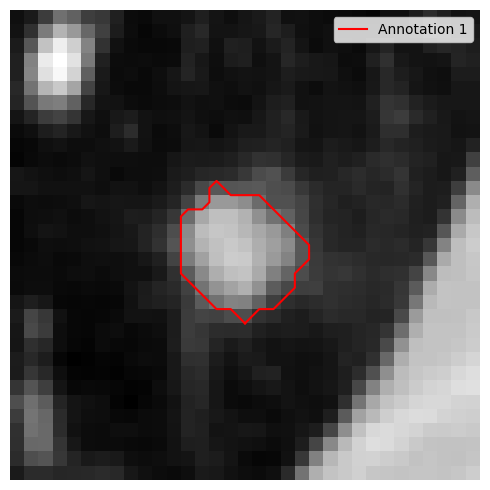

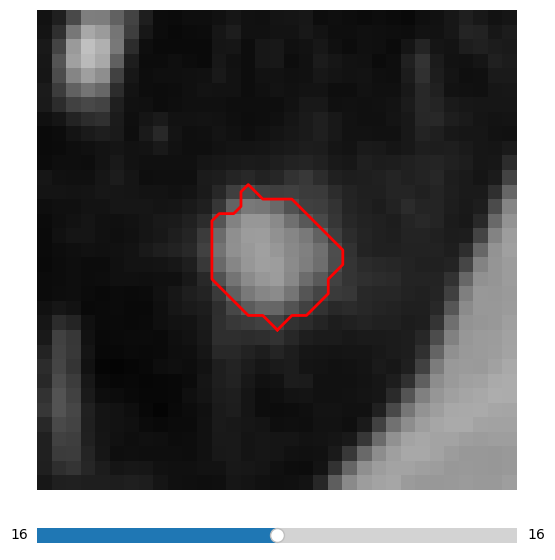

----------------------------------------------------------------------
Processing annotation 3 of 3
----------------------------------------------------------------------
Diameter: 12.48 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Fairly Subtle            | 3 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Medium Lobulation        | 3 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Non-Solid/Mixed          | 2 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [3 1 6 4 2 3 2 2 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


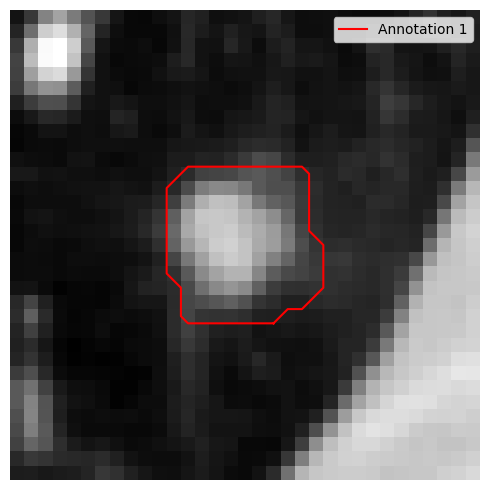

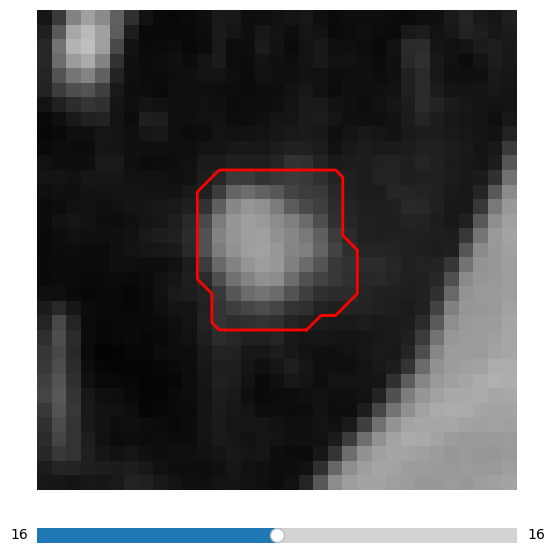

Processing nodule 2 of 2: LIDC-IDRI-0110-2
Found 3 annotations.
Volume shape: (0, 0, 16)


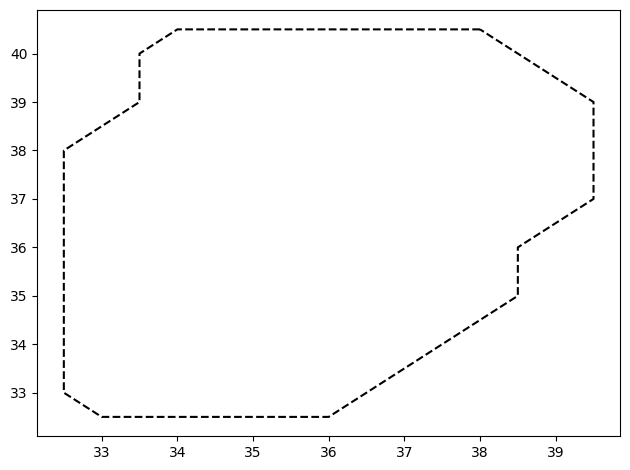

----------------------------------------------------------------------
Processing annotation 1 of 3
----------------------------------------------------------------------
Diameter: 7.90 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Moderately Unlikely      | 2 
Feature NunPy Array: [5 1 6 3 4 1 1 5 2]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


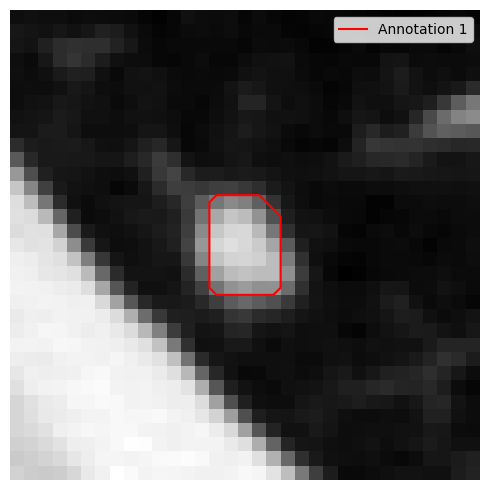

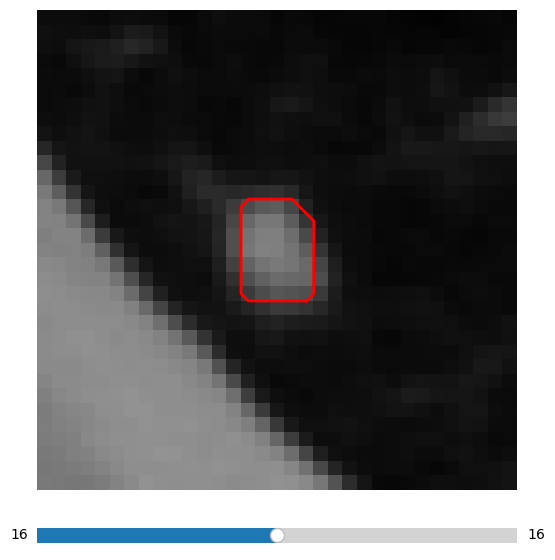

----------------------------------------------------------------------
Processing annotation 2 of 3
----------------------------------------------------------------------
Diameter: 7.90 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Medium Margin            | 3 
Lobulation         | Medium Lobulation        | 3 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [4 1 6 3 3 3 2 5 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


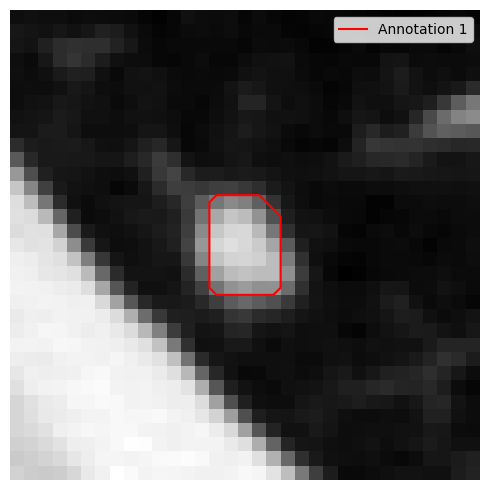

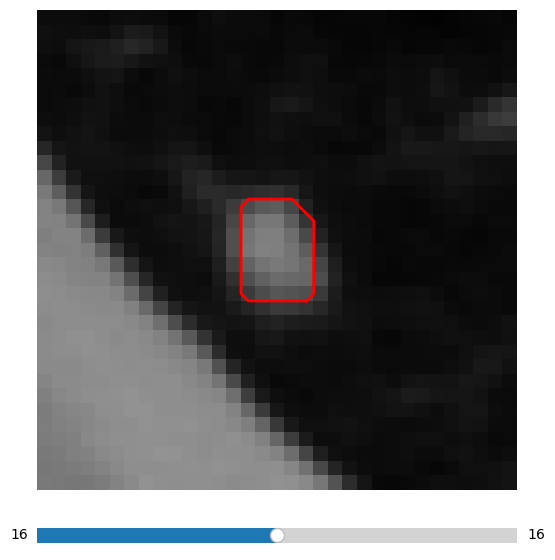

----------------------------------------------------------------------
Processing annotation 3 of 3
----------------------------------------------------------------------
Diameter: 10.96 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Medium Margin            | 3 
Lobulation         | Nearly No Lobulation     | 2 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid/Mixed              | 4 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [4 1 6 4 3 2 2 4 3]
Loading dicom files ... This may take a moment.
Volume shape: (33, 33, 33)


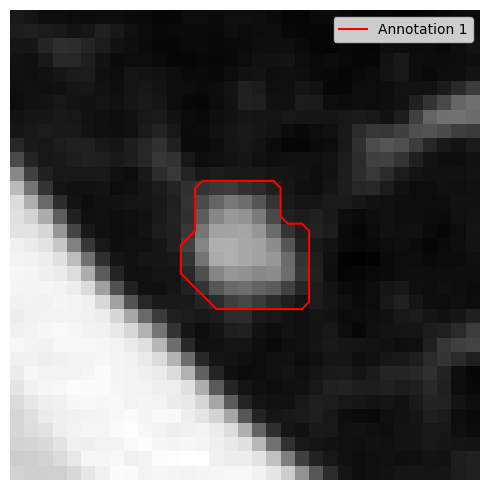

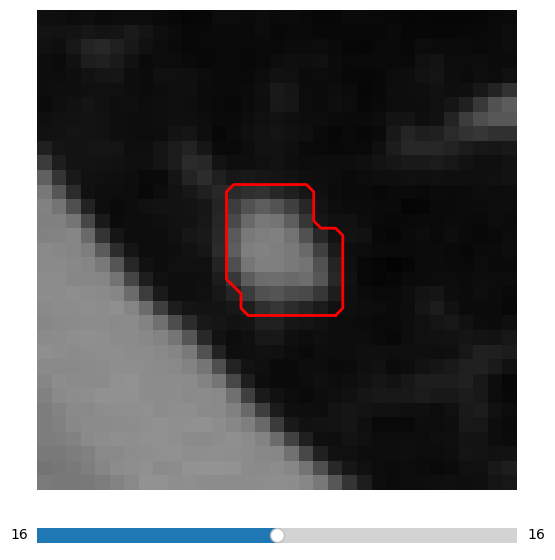

In [110]:
for scan_idx,scan in enumerate(scans):
    print("#"*80)
    print(f"Processing scan {scan_idx+1} of {scans.count()}: {scan.patient_id}")
    print(f"Found {len(scan.annotations)} annotations.")
    print("#"*80)

    vol = scan.to_volume()
    print(f"Volume shape: {vol.shape}")
    # TODO: Clamp HU values and Normalize volume, maybe normalize after bounding box is computed
    
    nodules = scan.cluster_annotations()
    for nod_idx,nod in enumerate(nodules):
        print("="*75)
        print(f"Processing nodule {nod_idx+1} of {len(nodules)}: {nod[0].scan.patient_id+'-'+str(nod_idx+1)}")
        print(f"Found {len(nod)} annotations.")
        print("="*75)
        
        if len(nod) >= 3:
            # Perform a consensus consolidation and 50% agreement level.
            cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=30)
            print(f"Volume shape: {vol[cbbox].shape}")
            
            # Get the central slice of the computed bounding box.
            k = int(0.5*(cbbox[2].stop - cbbox[2].start))

            # Set up the plot.
            # fig,ax = plt.subplots(1,1,figsize=(5,5))
            # ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray)
            
            # Plot the annotation contours for the kth slice.
            # colors = ['r', 'g', 'b', 'y']
            # for j in range(len(masks)):
            #     for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            #         label = "Annotation %d" % (j+1)
            #         print(f"Annotation {j+1} contour shape: {c.shape}")
            #         plt.plot(c[:,1], c[:,0], colors[j], label=label)

            # Plot the 50% consensus contour for the kth slice.
            for c in find_contours(cmask[:,:,k].astype(float), 0.5):
                plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

            ax.axis('off')
            ax.legend()
            plt.tight_layout()
            plt.show()
            
            for ann_idx,ann in enumerate(nod):
                print("-"*70)
                print(f"Processing annotation {ann_idx+1} of {len(nod)}")
                print("-"*70)
                if 5 < ann.diameter <= 12:
                    print(f"Diameter: {ann.diameter:.2f} - Medium Nodule Size")
                elif ann.diameter <= 5:
                    print(f"Diameter: {ann.diameter:.2f} - Small Nodule Size")
                elif ann.diameter > 12:
                    print(f"Diameter: {ann.diameter:.2f} - Large Nodule Size")
                
                ann.print_formatted_feature_table()
                features = ann.feature_vals()
                print(f"Feature NunPy Array: {features}")
                
                vol,mask = ann.uniform_cubic_resample(side_length=32)
                print(f"Volume shape: {vol.shape}")

                fig,ax = plt.subplots(1,1,figsize=(5,5))
                ax.imshow(vol[:,:,15], cmap=plt.cm.gray)

                for c in find_contours(mask[:,:,15].astype(float), 0.5):
                    plt.plot(c[:,1], c[:,0], 'r', label='Annotation 1')

                ax.legend()
                ax.axis('off')
                plt.tight_layout()
                plt.show()
                
                pl.utils.volume_viewer(vol, mask, ls='-', lw=2, c='r')
                # print(f"Annotation Diameter: {ann.diameter:.2f} mm")
                # print(f"Malignancy: {ann.malignancy} - {ann.Malignancy}")
                # print(f"Texture: {ann.texture} - {ann.Texture}")
                # print(f"Spiculation: {ann.spiculation} - {ann.Spiculation}")
                # print(f"Lobulation: {ann.lobulation} - {ann.Lobulation}")
                # print(f"Sphericity: {ann.sphericity} - {ann.Sphericity}")
                # print(f"Margin: {ann.margin} - {ann.Margin}")
                # print(f"Subtlety: {ann.subtlety} - {ann.Subtlety}")
                # print(f"Internal Structure: {ann.internalStructure} - {ann.InternalStructure}")
                # print(f"Calcification: {ann.calcification} - {ann.Calcification}")


In [3]:
anns = pl.query(pl.Annotation).join(pl.Scan)\
         .filter(pl.Scan.slice_thickness == 3,
                 pl.Annotation.malignancy != 3)
         
print(anns.count())


575


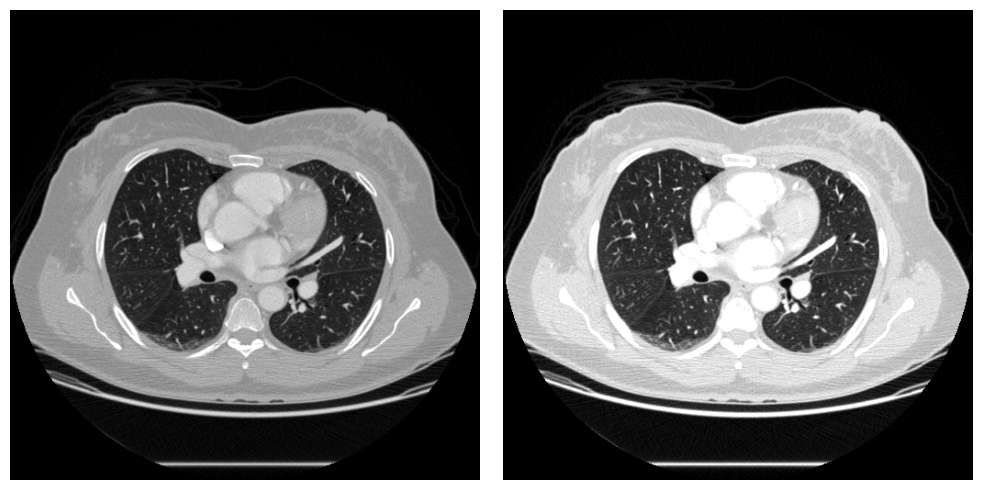

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted figsize for better display

# Display the first slice
ax[0].imshow(vol[:,:,100], cmap='gray')
ax[0].axis('off')  # Turn off axis for first subplot

# Display the second slice with normalization
ax[1].imshow(normalize(vol[:,:,100]), cmap='gray')
ax[1].axis('off')  # Turn off axis for second subplot

plt.tight_layout()
plt.show()


Number of nodules: 4
Number of annotations: 1
Consensus mask shape: (53, 54, 7)
Bounding box: (slice(305, 358, None), slice(98, 152, None), slice(48, 55, None))
Slice shape: (53, 54, 7)


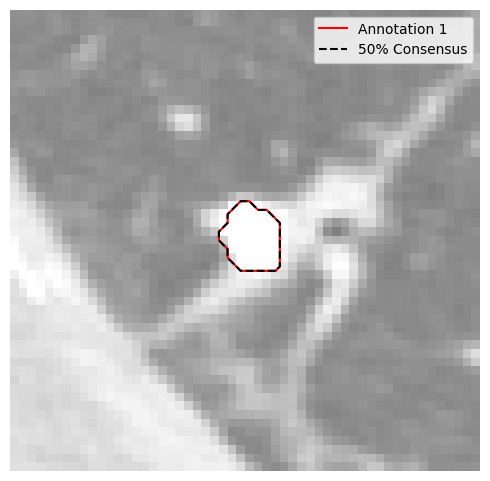

[[-752 -742 -740 ... -753 -661 -539]
 [-772 -761 -767 ... -738 -640 -511]
 [-792 -798 -787 ... -707 -685 -544]
 ...
 [ -87  -97 -142 ... -731 -740 -740]
 [ -93  -70 -124 ... -802 -810 -778]
 [ -64  -58  -67 ... -735 -742 -724]]


In [84]:
# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[1]

print(f"Number of nodules: {len(nods)}")
print(f"Number of annotations: {len(anns)}")

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,pad=[(20,20), (20,20), (0,0)])

print(f"Consensus mask shape: {cmask.shape}")
print(f"Bounding box: {cbbox}")

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)
print(f"Slice shape: {vol[cbbox].shape}")

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
#plt.savefig("../images/consensus.png", bbox_inches="tight")
plt.show()

## 3) 2D Dataset Creation

In [5]:
# Query the scans just once
scans = pl.query(pl.Scan).limit(100).all()
print(f"Found {len(scans)} scans")

# Prepare to collect counts
filtered_nods_count = 0
filtered_ann_count = 0
total_nods_count = 0
total_ann_count = 0

# Process each scan
for scan in tqdm(scans):
    nodules = scan.cluster_annotations(verbose=False)
    total_nods_count += len(nodules)
    total_ann_count += sum(len(nod) for nod in nodules)
    
    # Filter nodules with at least 3 annotations
    filtered_nods = [nod for nod in nodules if len(nod) >= 3]
    filtered_nods_count += len(filtered_nods)
    filtered_ann_count += sum(len(nod) for nod in filtered_nods)

print(f"Found {filtered_nods_count} nodules with {filtered_ann_count} annotations in {len(scans)} scans.")
print(f"Found {total_nods_count} nodules with {total_ann_count} annotations in {len(scans)} scans.")


Found 100 scans


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]

Found 185 nodules with 684 annotations in 100 scans.
Found 303 nodules with 855 annotations in 100 scans.


### 2.1) Visualising Data on first five scans

Found 5 scans


  0%|          | 0/5 [00:00<?, ?it/s]

################################################################################
Processing scan 1 of 5: LIDC-IDRI-0078
Found 13 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Processing nodule 1 of 3: LIDC-IDRI-0078-1
Found 4 annotations.
Cropped volume shape: (98, 108, 6)
Annotation 1 contour shape: (99, 2)
Annotation 2 contour shape: (111, 2)
Annotation 2 contour shape: (5, 2)
Annotation 3 contour shape: (5, 2)
Annotation 3 contour shape: (145, 2)
Annotation 4 contour shape: (113, 2)


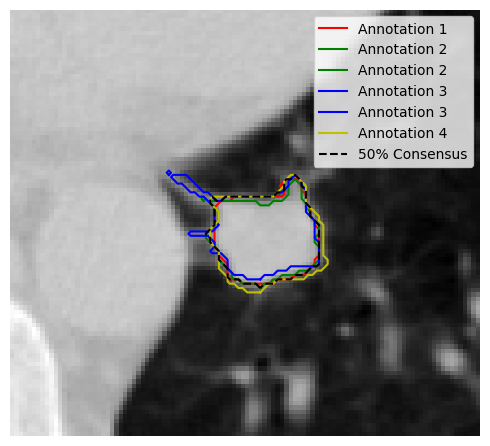

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 19.50 - Medium/Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | Nearly No Spiculation    | 2 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [4 1 6 4 4 1 2 5 3]
----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 27.

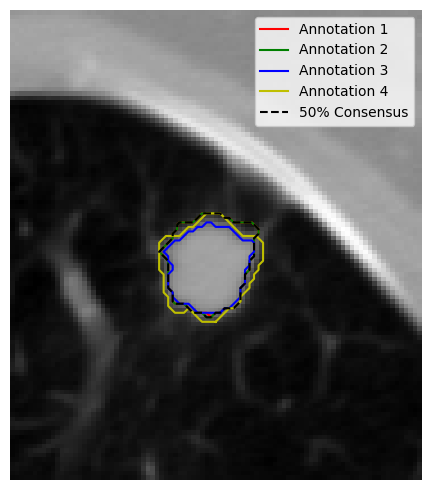

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 20.84 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 3 4 1 1 5 3]
----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 20.89 - La

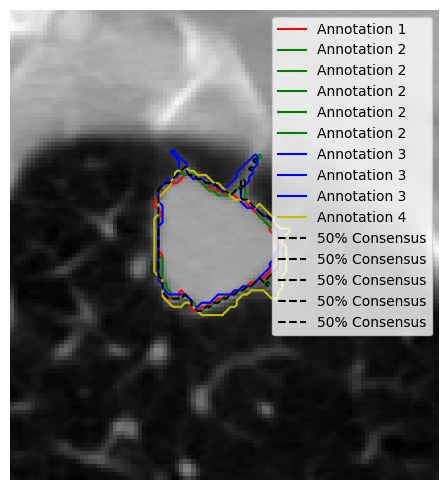

 20%|██        | 1/5 [00:03<00:14,  3.53s/it]

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 23.30 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Non-central              | 4 
Sphericity         | Ovoid                    | 3 
Margin             | Sharp                    | 5 
Lobulation         | Nearly No Lobulation     | 2 
Spiculation        | Medium Spiculation       | 3 
Texture            | Solid                    | 5 
Malignancy         | Moderately Suspicious    | 4 
Feature NunPy Array: [5 1 4 3 5 2 3 5 4]
----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 32.81 - La

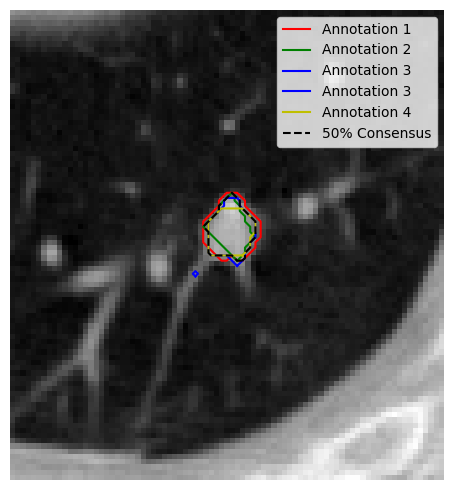

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 12.68 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Fairly Subtle            | 3 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Round                    | 5 
Margin             | Sharp                    | 5 
Lobulation         | Marked Lobulation        | 5 
Spiculation        | Marked Spiculation       | 5 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [3 1 6 5 5 5 5 5 5]
----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 10.40 - M

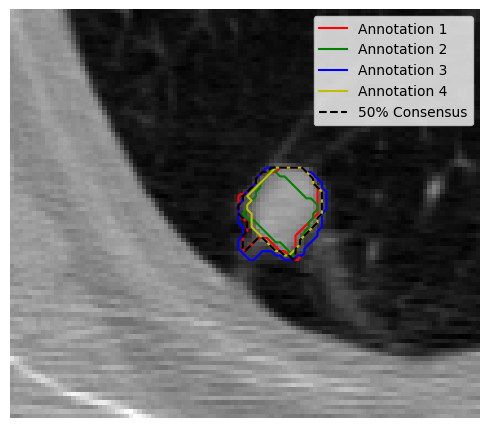

 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 23.92 - Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Sharp                    | 5 
Lobulation         | Marked Lobulation        | 5 
Spiculation        | Near Marked Spiculation  | 4 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 
Feature NunPy Array: [5 1 6 4 5 5 4 5 5]
----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 24.27 - La

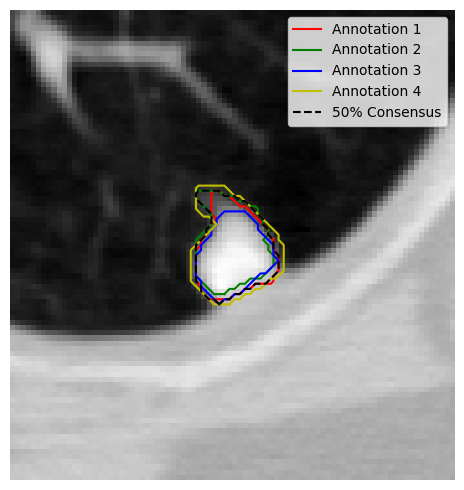

 60%|██████    | 3/5 [00:07<00:04,  2.20s/it]

----------------------------------------------------------------------
Processing annotation 1 of 4
----------------------------------------------------------------------
Diameter: 17.11 - Medium/Large Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Fairly Subtle            | 3 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Medium Margin            | 3 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [3 1 6 3 3 1 1 5 3]
----------------------------------------------------------------------
Processing annotation 2 of 4
----------------------------------------------------------------------
Diameter: 16.

 80%|████████  | 4/5 [00:08<00:01,  1.88s/it]

################################################################################
Processing scan 5 of 5: LIDC-IDRI-0110
Found 6 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Processing nodule 1 of 2: LIDC-IDRI-0110-1
Found 3 annotations.
Cropped volume shape: (81, 81, 4)
Annotation 1 contour shape: (59, 2)
Annotation 2 contour shape: (47, 2)
Annotation 3 contour shape: (63, 2)


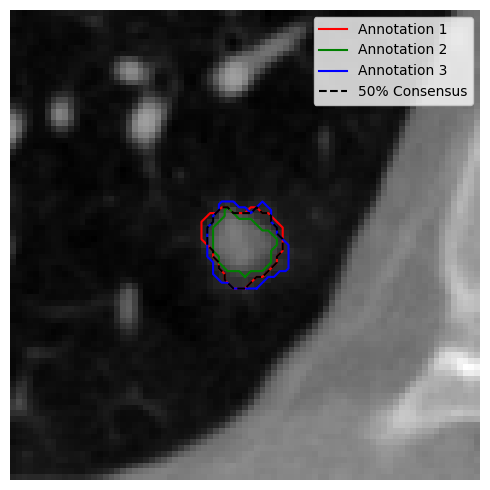

----------------------------------------------------------------------
Processing annotation 1 of 3
----------------------------------------------------------------------
Diameter: 11.55 - Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Round                    | 5 
Margin             | Medium Margin            | 3 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 
Feature NunPy Array: [5 1 6 5 3 1 1 5 3]
----------------------------------------------------------------------
Processing annotation 2 of 3
----------------------------------------------------------------------
Diameter: 10.17 - M

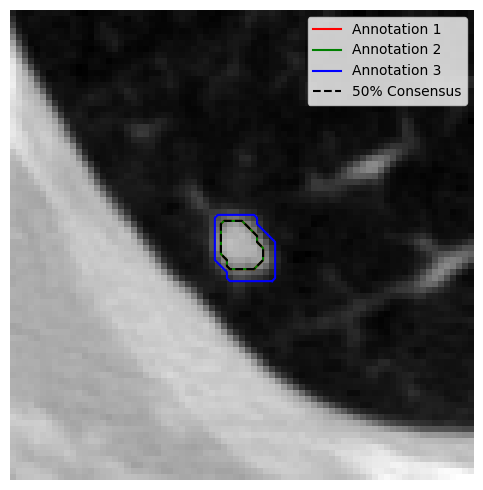

100%|██████████| 5/5 [00:10<00:00,  2.08s/it]

----------------------------------------------------------------------
Processing annotation 1 of 3
----------------------------------------------------------------------
Diameter: 7.90 - Small/Medium Nodule Size
Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Moderately Unlikely      | 2 
Feature NunPy Array: [5 1 6 3 4 1 1 5 2]
----------------------------------------------------------------------
Processing annotation 2 of 3
----------------------------------------------------------------------
Diameter: 7.90

In [10]:
# Query the scans just once
scans = pl.query(pl.Scan).limit(5).all()
print(f"Found {len(scans)} scans")

for scan_idx,scan in enumerate(tqdm(scans)):
    print("#"*80)
    print(f"Processing scan {scan_idx+1} of {len(scans)}: {scan.patient_id}")
    print(f"Found {len(scan.annotations)} annotations.")
    print("#"*80)

    vol = scan.to_volume()
    # print(f"Volume shape: {vol.shape}")
    # TODO: Clamp HU values and Normalize volume, maybe normalize after bounding box is computed
    
    # Cluster the annotations for each nodule
    nodules = scan.cluster_annotations()
    
    # Filter nodules with at least 3 annotations
    nodules = [nod for nod in nodules if len(nod) >= 3]
    
    # Process each nodule
    for nod_idx,nod in enumerate(nodules):
        
        print("="*75)
        print(f"Processing nodule {nod_idx+1} of {len(nodules)}: {nod[0].scan.patient_id+'-'+str(nod_idx+1)}")
        print(f"Found {len(nod)} annotations.")
        print("="*75)
        
        # Perform a consensus consolidation and 50% agreement level.
        cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=[(32,32), (32,32), (0,0)])
        
        cropped_vol = vol[cbbox]
        print(f"Cropped volume shape: {cropped_vol.shape}")
        
        # Get the central slice of the computed bounding box.
        k = int(0.5*(cbbox[2].stop - cbbox[2].start))
        # Set up the plot.
        fig,ax = plt.subplots(1,1,figsize=(5,5))
        ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray)
        
        # Plot the annotation contours for the kth slice.
        colors = ['r', 'g', 'b', 'y']
        for j in range(len(masks)):
            for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
                label = "Annotation %d" % (j+1)
                print(f"Annotation {j+1} contour shape: {c.shape}")
                plt.plot(c[:,1], c[:,0], colors[j], label=label)
                
        # Plot the 50% consensus contour for the kth slice.
        for c in find_contours(cmask[:,:,k].astype(float), 0.5):
            plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')
            
        ax.axis('off')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        for ann_idx,ann in enumerate(nod):
            print("-"*70)
            print(f"Processing annotation {ann_idx+1} of {len(nod)}")
            print("-"*70)
            
            if ann.diameter <= 6:
                print(f"Diameter: {ann.diameter:.2f} - Small Nodule Size")
            elif 6 < ann.diameter <= 10:
                print(f"Diameter: {ann.diameter:.2f} - Small/Medium Nodule Size")
            elif 10 < ann.diameter <= 15:
                print(f"Diameter: {ann.diameter:.2f} - Medium Nodule Size")
            elif 15 < ann.diameter <= 20:
                print(f"Diameter: {ann.diameter:.2f} - Medium/Large Nodule Size")
            elif ann.diameter > 20:
                print(f"Diameter: {ann.diameter:.2f} - Large Nodule Size")
                
            ann.print_formatted_feature_table()
            features = ann.feature_vals()
            print(f"Feature NunPy Array: {features}")
            
            # print(f"Annotation Diameter: {ann.diameter:.2f} mm")
            # print(f"Malignancy: {ann.malignancy} - {ann.Malignancy}")
            # print(f"Texture: {ann.texture} - {ann.Texture}")
            # print(f"Spiculation: {ann.spiculation} - {ann.Spiculation}")
            # print(f"Lobulation: {ann.lobulation} - {ann.Lobulation}")
            # print(f"Sphericity: {ann.sphericity} - {ann.Sphericity}")
            # print(f"Margin: {ann.margin} - {ann.Margin}")
            # print(f"Subtlety: {ann.subtlety} - {ann.Subtlety}")
            # print(f"Internal Structure: {ann.internalStructure} - {ann.InternalStructure}")
            # print(f"Calcification: {ann.calcification} - {ann.Calcification}")


Found 5 scans


  0%|          | 0/5 [00:00<?, ?it/s]

################################################################################
Processing scan 1 of 5: LIDC-IDRI-0078
Found 13 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Processing nodule 1 of 3: LIDC-IDRI-0078-1
Found 4 annotations.
Cropped volume shape: (98, 108, 6)


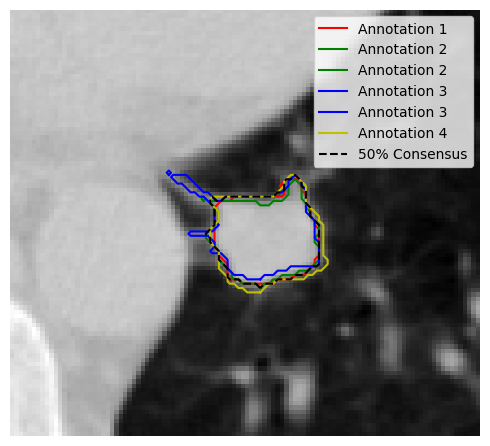

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         5         4                  1              6           4       3   

   Lobulation  Spiculation  Texture  Malignancy  
0           2            2        5           3  
Processing nodule 2 of 3: LIDC-IDRI-0078-2
Found 4 annotations.
Cropped volume shape: (104, 91, 6)


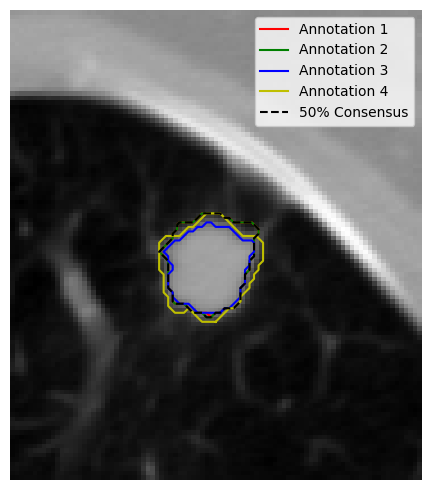

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         5         5                  1              6           4       2   

   Lobulation  Spiculation  Texture  Malignancy  
0           3            2        4           3  
Processing nodule 3 of 3: LIDC-IDRI-0078-3
Found 4 annotations.
Cropped volume shape: (114, 104, 8)


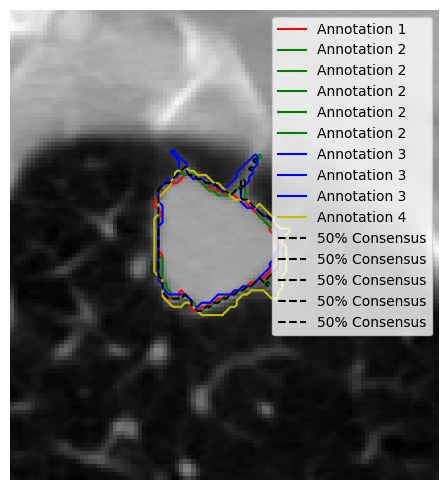

 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         5         5                  1              5           4       3   

   Lobulation  Spiculation  Texture  Malignancy  
0           3            3        5           4  
################################################################################
Processing scan 2 of 5: LIDC-IDRI-0069
Found 9 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Processing nodule 1 of 2: LIDC-IDRI-0069-1
Found 4 annotations.
Cropped volume shape: (90, 83, 9)


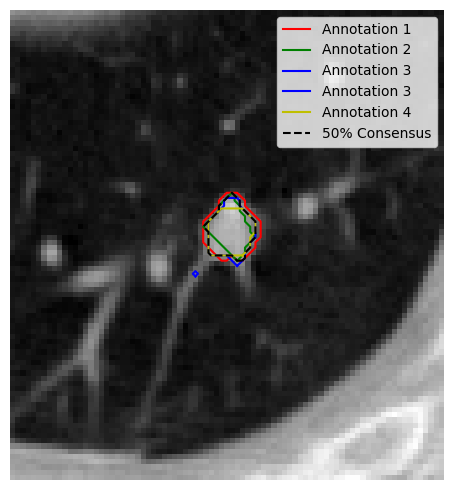

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         3         2                  1              6           4       4   

   Lobulation  Spiculation  Texture  Malignancy  
0           4            5        5           3  
Processing nodule 2 of 2: LIDC-IDRI-0069-2
Found 4 annotations.
Cropped volume shape: (93, 107, 11)


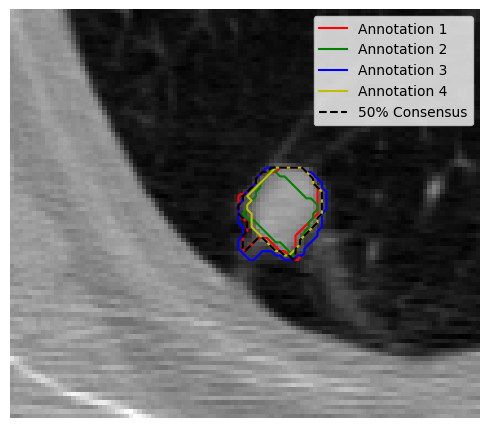

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         5         5                  1              6           4       3   

   Lobulation  Spiculation  Texture  Malignancy  
0           4            3        5           3  


 40%|████      | 2/5 [00:04<00:07,  2.39s/it]

################################################################################
Processing scan 3 of 5: LIDC-IDRI-0079
Found 4 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Processing nodule 1 of 1: LIDC-IDRI-0079-1
Found 4 annotations.
Cropped volume shape: (91, 86, 5)


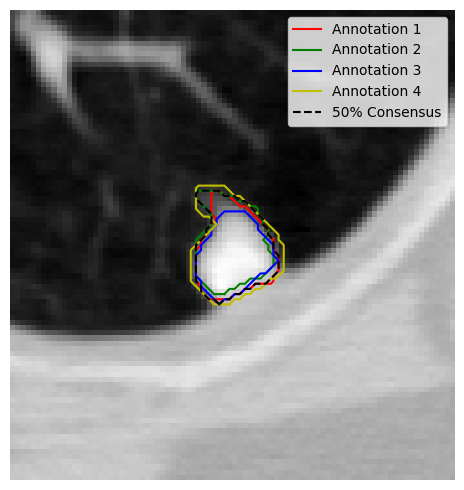

 60%|██████    | 3/5 [00:06<00:03,  1.93s/it]

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         4         5                  1              6           4       4   

   Lobulation  Spiculation  Texture  Malignancy  
0           2            1        5           3  
################################################################################
Processing scan 4 of 5: LIDC-IDRI-0101
Found 2 annotations.
################################################################################
Loading dicom files ... This may take a moment.


 80%|████████  | 4/5 [00:07<00:01,  1.75s/it]

################################################################################
Processing scan 5 of 5: LIDC-IDRI-0110
Found 6 annotations.
################################################################################
Loading dicom files ... This may take a moment.
Processing nodule 1 of 2: LIDC-IDRI-0110-1
Found 3 annotations.
Cropped volume shape: (81, 81, 4)


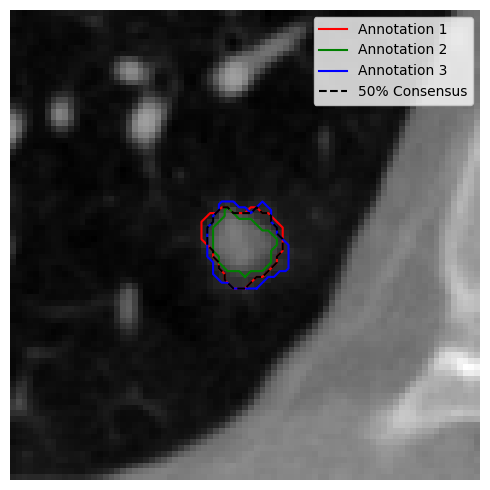

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         3         4                  1              6           5       2   

   Lobulation  Spiculation  Texture  Malignancy  
0           3            2        3           3  
Processing nodule 2 of 2: LIDC-IDRI-0110-2
Found 3 annotations.
Cropped volume shape: (78, 77, 3)


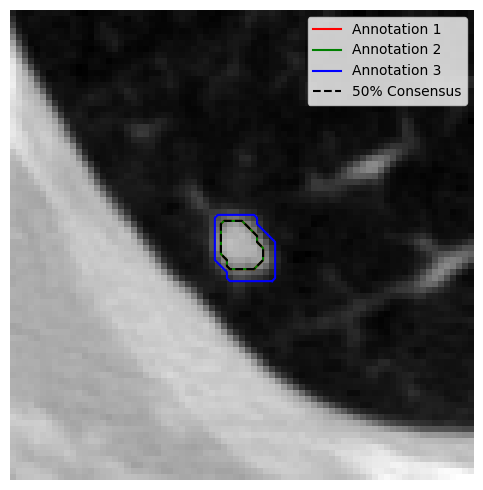

100%|██████████| 5/5 [00:08<00:00,  1.80s/it]

   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         2         4                  1              6           3       3   

   Lobulation  Spiculation  Texture  Malignancy  
0           2            2        5           3  
   Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0         5         4                  1              6           4       3   
1         5         5                  1              6           4       2   
2         5         5                  1              5           4       3   
3         3         2                  1              6           4       4   
4         5         5                  1              6           4       3   
5         4         5                  1              6           4       4   
6         3         4                  1              6           5       2   
7         2         4                  1              6           3       3   

   Lobulation  Spiculation  T

In [27]:
# Define a function to calculate the median features
def median_features(annotations):
    features_dict = {}
    # Define the feature names and initialize lists
    feature_names = ['Diameter','Subtlety', 'Internalstructure', 'Calcification', 'Sphericity', 
                     'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']
    for name in feature_names:
        features_dict[name] = []

    # Collect all feature values from the annotations
    for ann in annotations:
        features = ann.feature_vals()
        if ann.diameter <= 6:
            # Small Nodule Size
            features = np.insert(features, 0, 1, axis=0)
        elif 6 < ann.diameter <= 10:
            # Small/Medium Nodule Size
            features = np.insert(features, 0, 2, axis=0)
        elif 10 < ann.diameter <= 15:
            # Medium Nodule Size
            features = np.insert(features, 0, 3, axis=0)
        elif 15 < ann.diameter <= 20:
            # Medium/Large Nodule Size
            features = np.insert(features, 0, 4, axis=0)
        elif ann.diameter > 20:
            # Large Nodule Size
            features = np.insert(features, 0, 5, axis=0)
        
        # Append the features to the dictionary
        for name, value in zip(feature_names, features):
            features_dict[name].append(value)          

    # Calculate the median for each feature
    median_dict = {name: int(np.median(values)) for name, values in features_dict.items()}
    return median_dict

all_median_features = []

# Query the scans just once
scans = pl.query(pl.Scan).limit(5).all()
print(f"Found {len(scans)} scans")

for scan_idx,scan in enumerate(tqdm(scans)):
    print("#"*80)
    print(f"Processing scan {scan_idx+1} of {len(scans)}: {scan.patient_id}")
    print(f"Found {len(scan.annotations)} annotations.")
    print("#"*80)

    vol = scan.to_volume()
    
    # Cluster the annotations for each nodule
    nodules = scan.cluster_annotations()
    
    # Filter nodules with at least 3 annotations
    nodules = [nod for nod in nodules if len(nod) >= 3]
    
    # Process each nodule
    for nod_idx,nod in enumerate(nodules):
        
        print("="*75)
        print(f"Processing nodule {nod_idx+1} of {len(nodules)}: {nod[0].scan.patient_id+'-'+str(nod_idx+1)}")
        print(f"Found {len(nod)} annotations.")
        print("="*75)
        
        # Perform a consensus consolidation and 50% agreement level.
        cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=[(32,32), (32,32), (0,0)])

        # TODO: Preprocessing: Clamp HU values and Normalize volume and normalize after bounding box is computed
        cropped_vol = vol[cbbox]
        print(f"Cropped volume shape: {cropped_vol.shape}")
        
        # Get the central slice of the computed bounding box.
        k = int(0.5*(cbbox[2].stop - cbbox[2].start))
        # Set up the plot.
        fig,ax = plt.subplots(1,1,figsize=(5,5))
        ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray)
        
        # Plot the annotation contours for the kth slice.
        colors = ['r', 'g', 'b', 'y']
        for j in range(len(masks)):
            for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
                label = "Annotation %d" % (j+1)
                plt.plot(c[:,1], c[:,0], colors[j], label=label)
                
        # Plot the 50% consensus contour for the kth slice.
        for c in find_contours(cmask[:,:,k].astype(float), 0.5):
            plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')
            
        ax.axis('off')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        median_dict = median_features(nod)
        df = pd.DataFrame(median_dict, index=[0])
        print(df)
        
        median_dict = median_features(nod)
        
        # Process each slice of the nodule, and calculate the median features, save the slice, and add the directory to the dictionary
        for slice_idx in range(cropped_vol.shape[2]):
            # Get the slice
            slice_vol = cropped_vol[:,:,slice_idx]
            # Normalize the slice
            slice_vol = normalize(slice_vol)
            # Calculate the median features
            median_dict = median_features(nod)
            # Add the slice directory or identifier to the dictionary
            median_dict['ImageDir'] = f"{scan.patient_id}/NODULE-{nod_idx + 1}/SLICE-{slice_idx + 1}"
            # Append the dictionary to the list
            all_median_features.append(median_dict)
            
        median_dict['ImageDir'] = f"{scan.patient_id}/NODULE-{nod_idx + 1}/SLICE-"  # Add image directory or identifier
        all_median_features.append(median_dict)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_median_features)
print(df)


### 2.2) Save the central slice only

In [51]:
def plot_feature_counts(df):
    n_features = df.shape[1]
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Adjust grid size based on your number of features
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, feature in enumerate(df.columns):
        counts = df[feature].value_counts().sort_index()

        # Create a bar plot for each feature
        axes[i].bar(counts.index.astype(int), counts.values, color=plt.cm.get_cmap('Set3')(i / float(n_features)), alpha=0.7)
        axes[i].set_title(feature)
        axes[i].set_xlabel('Class')
        axes[i].set_ylabel('Sample Count')

        # Set x-ticks to be only integers
        axes[i].set_xticks(np.arange(min(counts.index), max(counts.index)+1, 1))  # Ensure every integer is shown

    plt.tight_layout()
    plt.show()

In [53]:
def plot_feature_counts(df):
    feature_ranges = {
        'Diameter': range(1, 6),
        'Subtlety': range(1, 6),
        'Internalstructure': range(1, 6),
        'Calcification': range(1, 7),  # Calcification ranges from 1 to 6
        'Sphericity': range(1, 6),
        'Margin': range(1, 6),
        'Lobulation': range(1, 6),
        'Spiculation': range(1, 6),
        'Texture': range(1, 6)
    }
    n_features = len(df.columns)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Adjust grid size based on your number of features
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, (feature, ax) in enumerate(zip(df.columns, axes)):
        # Get counts for each category and ensure all categories are represented
        counts = df[feature].value_counts().reindex(feature_ranges[feature], fill_value=0)
        
        # Create a bar plot for each feature
        ax.bar(counts.index, counts.values, color=plt.cm.get_cmap('Set3')(i / float(n_features)), alpha=0.7)
        ax.set_title(feature)
        ax.set_xlabel('Class')
        ax.set_ylabel('Sample Count')
        ax.set_xticks(counts.index)  # Set x-ticks to be exactly at every category

    plt.tight_layout()
    plt.show()

Found 1018 scans


  6%|▋         | 65/1018 [02:40<1:01:12,  3.85s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 10%|▉         | 99/1018 [05:55<1:00:09,  3.93s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 14%|█▎        | 139/1018 [08:41<1:03:03,  4.30s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 20%|██        | 204/1018 [12:52<42:07,  3.11s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 25%|██▍       | 251/1018 [15:23<37:37,  2.94s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|███▎      | 333/1018 [21:44<1:07:40,  5.93s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|███▎      | 341/1018 [22:22<52:07,  4.62s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 36%|███▌      | 369/1018 [24:23<29:12,  2.70s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 40%|███▉      | 407/1018 [27:44<56:12,  5.52s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 60%|██████    | 612/1018 [46:56<43:55,  6.49s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 70%|██████▉   | 712/1018 [55:33<26:41,  5.23s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 789/1018 [1:02:06<21:47,  5.71s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 791/1018 [1:02:14<18:08,  4.80s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 82%|████████▏ | 839/1018 [1:06:51<16:41,  5.60s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|██████████| 1018/1018 [1:25:24<00:00,  5.03s/it]
C:\Users\jerem\AppData\Local\Temp\ipykernel_6552\2037929612.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.bar(counts.index, counts.values, color=plt.cm.get_cmap('Set3')(i / float(n_features)), alpha=0.7)


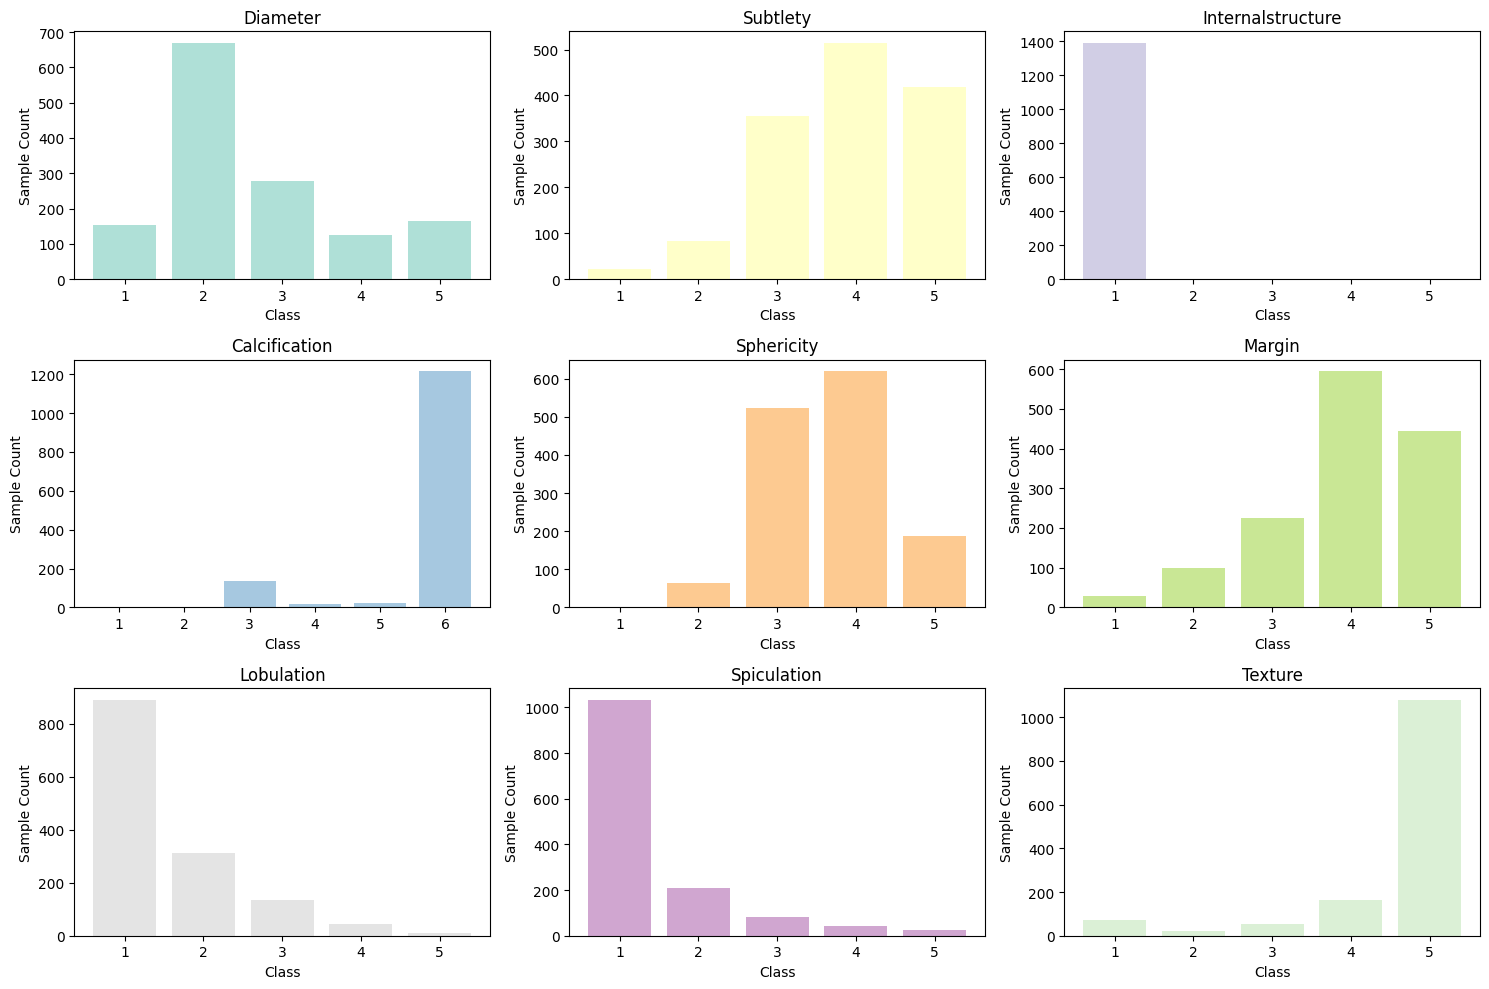

In [56]:
# Define a function to calculate the median features
def median_features(annotations):
    features_dict = {}
    # Define the feature names and initialize lists
    feature_names = ['Diameter','Subtlety', 'Internalstructure', 'Calcification', 'Sphericity', 
                     'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']
    for name in feature_names:
        features_dict[name] = []

    # Collect all feature values from the annotations
    for ann in annotations:
        features = ann.feature_vals()
        if ann.diameter <= 6:
            # Small Nodule Size
            features = np.insert(features, 0, 1, axis=0)
        elif 6 < ann.diameter <= 10:
            # Small/Medium Nodule Size
            features = np.insert(features, 0, 2, axis=0)
        elif 10 < ann.diameter <= 15:
            # Medium Nodule Size
            features = np.insert(features, 0, 3, axis=0)
        elif 15 < ann.diameter <= 20:
            # Medium/Large Nodule Size
            features = np.insert(features, 0, 4, axis=0)
        elif ann.diameter > 20:
            # Large Nodule Size
            features = np.insert(features, 0, 5, axis=0)
        
        # Append the features to the dictionary
        for name, value in zip(feature_names, features):
            features_dict[name].append(value)          

    # Calculate the median for each feature
    median_dict = {name: int(np.median(values)) for name, values in features_dict.items()}
    return median_dict

all_median_features = []

# Query the scans just once
scans = pl.query(pl.Scan).all()
print(f"Found {len(scans)} scans")

for scan_idx,scan in enumerate(tqdm(scans)):

    vol = scan.to_volume(verbose=False)
    
    # Cluster the annotations for each nodule
    nodules = scan.cluster_annotations()
    
    # Filter nodules with at least 3 annotations
    nodules = [nod for nod in nodules if len(nod) >= 3]
    
    # Process each nodule
    for nod_idx,nod in enumerate(nodules):
        # Perform a consensus consolidation and 50% agreement level.
        cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=[(32,32), (32,32), (0,0)])

        # Crop the volume to the computed consensus bounding box.
        cropped_vol = vol[cbbox]
        
        # Get the central slice of the computed bounding box.
        k = int(0.5*(cbbox[2].stop - cbbox[2].start))
        central_slice = cropped_vol[:,:,k]
        
        # Clamp the HU values and Normalize the slice
        # central_slice = normalize(central_slice)
        
        # Calculate the median features
        median_dict = median_features(nod)
        
        # Save the central slice to disk
        slice_dir = f"./dataset/2D-v1/slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
        # os.makedirs(slice_dir, exist_ok=True)
        # plt.imsave(f"{slice_dir}/SLICE-{k + 1}.png", central_slice, cmap='gray')
        
        # Add the slice directory or identifier to the dictionary
        median_dict['ImageDir'] = f"{slice_dir}/SLICE-{k + 1}.png"
        
        # Append the dictionary to the list
        all_median_features.append(median_dict)

# Call the function with the DataFrame
df = pd.DataFrame(all_median_features)
df = df.drop(columns=['ImageDir', 'Malignancy'])
plot_feature_counts(df)

In [57]:
# Printing counts for each characteristic
for column in df.columns:
    print(f"Counts for {column}:")
    print(df[column].value_counts())
    print("\n")

Counts for Diameter:
Diameter
2    669
3    278
5    165
1    154
4    126
Name: count, dtype: int64


Counts for Subtlety:
Subtlety
4    514
5    418
3    356
2     82
1     22
Name: count, dtype: int64


Counts for Internalstructure:
Internalstructure
1    1388
4       2
2       2
Name: count, dtype: int64


Counts for Calcification:
Calcification
6    1214
3     138
5      21
4      17
2       2
Name: count, dtype: int64


Counts for Sphericity:
Sphericity
4    619
3    523
5    187
2     63
Name: count, dtype: int64


Counts for Margin:
Margin
4    594
5    445
3    226
2     98
1     29
Name: count, dtype: int64


Counts for Lobulation:
Lobulation
1    891
2    313
3    134
4     43
5     11
Name: count, dtype: int64


Counts for Spiculation:
Spiculation
1    1033
2     209
3      83
4      43
5      24
Name: count, dtype: int64


Counts for Texture:
Texture
5    1080
4     163
1      72
3      55
2      22
Name: count, dtype: int64




Found 5 scans


  0%|          | 0/5 [00:00<?, ?it/s]

Cropped volume shape: (74, 84, 6), Type: int16
Resized volume shape: (100, 100, 6), Type: int16
Processed volume shape: (100, 100, 6), Type: float32


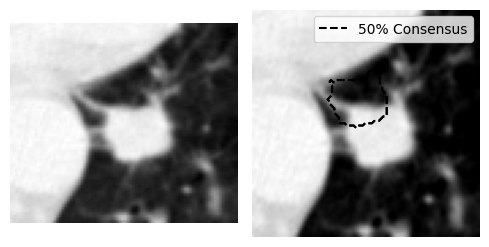

Cropped volume shape: (80, 67, 6), Type: int16
Resized volume shape: (100, 100, 6), Type: int16
Processed volume shape: (100, 100, 6), Type: float32


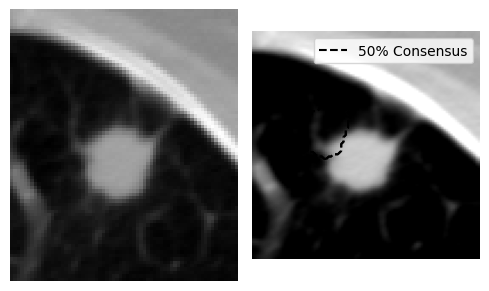

Cropped volume shape: (90, 80, 8), Type: int16
Resized volume shape: (100, 100, 8), Type: int16
Processed volume shape: (100, 100, 8), Type: float32


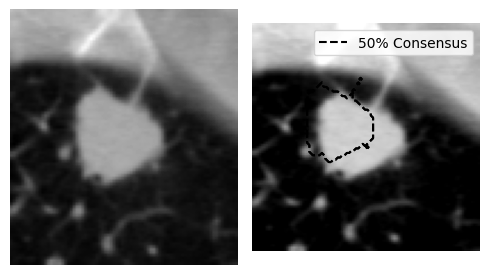

 20%|██        | 1/5 [00:03<00:13,  3.36s/it]

Cropped volume shape: (66, 59, 9), Type: int16
Resized volume shape: (100, 100, 9), Type: int16
Processed volume shape: (100, 100, 9), Type: float32


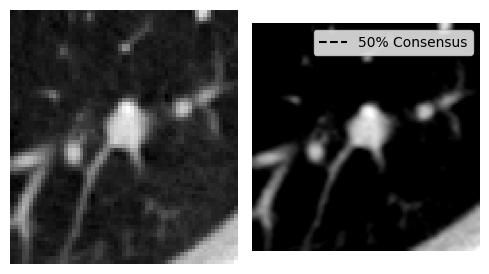

Cropped volume shape: (69, 83, 11), Type: int16
Resized volume shape: (100, 100, 11), Type: int16
Processed volume shape: (100, 100, 11), Type: float32


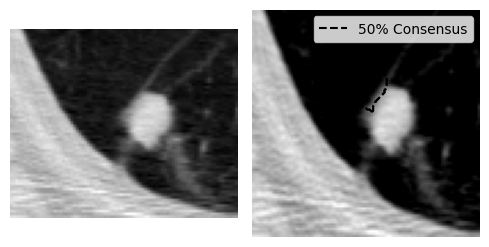

 40%|████      | 2/5 [00:06<00:09,  3.24s/it]

Cropped volume shape: (67, 62, 5), Type: int16
Resized volume shape: (100, 100, 5), Type: int16
Processed volume shape: (100, 100, 5), Type: float32


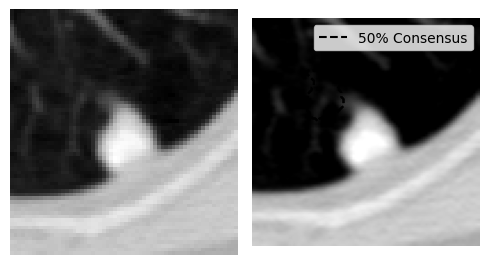

 80%|████████  | 4/5 [00:09<00:02,  2.13s/it]

Cropped volume shape: (57, 57, 4), Type: int16
Resized volume shape: (100, 100, 4), Type: int16
Processed volume shape: (100, 100, 4), Type: float32


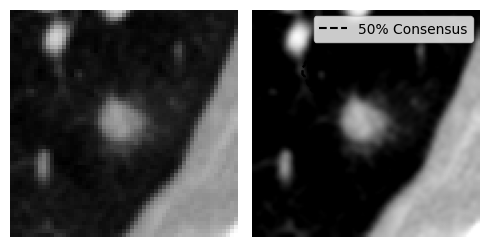

Cropped volume shape: (54, 53, 3), Type: int16
Resized volume shape: (100, 100, 3), Type: int16
Processed volume shape: (100, 100, 3), Type: float32


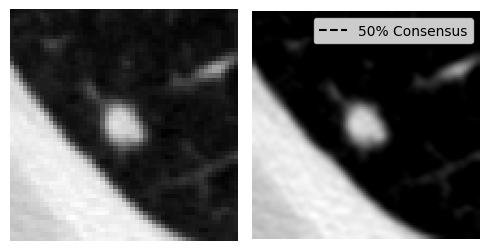

100%|██████████| 5/5 [00:11<00:00,  2.31s/it]

    Diameter  Subtlety  Internalstructure  Calcification  Sphericity  Margin  \
0          5         4                  1              6           4       3   
1          5         4                  1              6           4       3   
2          5         4                  1              6           4       3   
3          5         4                  1              6           4       3   
4          5         4                  1              6           4       3   
5          5         4                  1              6           4       3   
6          5         5                  1              6           4       2   
7          5         5                  1              6           4       2   
8          5         5                  1              6           4       2   
9          5         5                  1              6           4       2   
10         5         5                  1              6           4       2   
11         5         5                  

In [85]:
import cv2

def clamp_and_normalize_volume(volume, min_hu=-800, max_hu=250):
    # Clamp the HU values
    clamped_volume = np.clip(volume, min_hu, max_hu)

    # Normalize the clamped values to the range 0-1
    normalized_volume = (clamped_volume - min_hu) / (max_hu - min_hu)

    return normalized_volume

# Define a function to calculate the median features
def median_features(annotations):
    features_dict = {}
    # Define the feature names and initialize lists
    feature_names = ['Diameter','Subtlety', 'Internalstructure', 'Calcification', 'Sphericity', 
                     'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']
    for name in feature_names:
        features_dict[name] = []

    # Collect all feature values from the annotations
    for ann in annotations:
        features = ann.feature_vals()
        if ann.diameter <= 6:
            # Small Nodule Size
            features = np.insert(features, 0, 1, axis=0)
        elif 6 < ann.diameter <= 10:
            # Small/Medium Nodule Size
            features = np.insert(features, 0, 2, axis=0)
        elif 10 < ann.diameter <= 15:
            # Medium Nodule Size
            features = np.insert(features, 0, 3, axis=0)
        elif 15 < ann.diameter <= 20:
            # Medium/Large Nodule Size
            features = np.insert(features, 0, 4, axis=0)
        elif ann.diameter > 20:
            # Large Nodule Size
            features = np.insert(features, 0, 5, axis=0)
        
        # Append the features to the dictionary
        for name, value in zip(feature_names, features):
            features_dict[name].append(value)          

    # Calculate the median for each feature
    median_dict = {name: int(np.median(values)) for name, values in features_dict.items()}
    return median_dict

all_median_features = []

# Query the scans just once
scans = pl.query(pl.Scan).limit(5).all()
print(f"Found {len(scans)} scans")

for scan_idx,scan in enumerate(tqdm(scans)):

    vol = scan.to_volume(verbose=False)
    
    # Cluster the annotations for each nodule
    nodules = scan.cluster_annotations()
    
    # Filter nodules with at least 3 annotations
    nodules = [nod for nod in nodules if len(nod) >= 3]
    
    # Process each nodule
    for nod_idx,nod in enumerate(nodules):
        # Perform a consensus consolidation and 50% agreement level.
        cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=[(20,20), (20,20), (0,0)])

        # TODO: Preprocessing: Clamp HU values and Normalize volume and normalize after bounding box is computed
        cropped_vol = vol[cbbox]
        print(f"Cropped volume shape: {cropped_vol.shape}, Type: {cropped_vol.dtype}")
        
        
        # Resize the cropped volume to 100x100xZ
        output_shape = (*(100,100), cropped_vol.shape[2])
        resized_volume = np.zeros(output_shape, dtype=cropped_vol.dtype)
        for i in range(cropped_vol.shape[2]):  # Iterate through the depth
            resized_volume[:, :, i] = cv2.resize(cropped_vol[:, :, i], (100,100), interpolation=cv2.INTER_CUBIC)
        
        print(f"Resized volume shape: {resized_volume.shape}, Type: {resized_volume.dtype}")
        
        # Apply preprocessing to the cropped volume
        processed_vol = clamp_and_normalize_volume(resized_volume).astype(np.float32)
        print(f"Processed volume shape: {processed_vol.shape}, Type: {processed_vol.dtype}")
        
        # Visualize the central slice of the computed bounding box
        k = int(0.5*(cbbox[2].stop - cbbox[2].start))
        central_slice = cropped_vol[:,:,k]
        preprocess_slice = processed_vol[:,:,k]
        
        # interpolate
        # central_slice = cv2.resize(central_slice, (100, 100), interpolation=cv2.INTER_CUBIC)
        # preprocess_slice = cv2.resize(preprocess_slice, (100, 100), interpolation=cv2.INTER_CUBIC)
        
        # Set up the plot.
        fig,ax = plt.subplots(1,2,figsize=(5,5))
        ax[0].imshow(central_slice, cmap=plt.cm.gray)
        # Plot the 50% consensus contour for the kth slice.
        for c in find_contours(cmask[:,:,k].astype(float), 0.5):
            plt.plot(c[:,1], c[:,0], '--k')
        ax[0].axis('off')
        
        # Plot the annotation contours for the kth slice.
        # colors = ['r', 'g', 'b', 'y']
        # for j in range(len(masks)):
        #     for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        #         label = "Annotation %d" % (j+1)
        #         print(f"Annotation {j+1} contour shape: {c.shape}")
        #         plt.plot(c[:,1], c[:,0], colors[j], label=label)
        
        ax[1].imshow(preprocess_slice, cmap=plt.cm.gray)
        # Plot the 50% consensus contour for the kth slice.
        first_label = True
        for c in find_contours(cmask[:,:,k].astype(float), 0.5):
            if first_label:
                plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')
                first_label = False
            else:
                plt.plot(c[:,1], c[:,0], '--k')
        ax[1].axis('off')
        ax[1].legend()

        plt.tight_layout()
        plt.show()
        
        # Get the central slice of the computed bounding box.
        central_slice = processed_vol[:,:,k]
        
        # Calculate the median features
        median_dict = median_features(nod)
        
        # Save the central slice to disk
        slice_dir = f"./dataset/2D-v2/slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
        # os.makedirs(slice_dir, exist_ok=True)
        # plt.imsave(f"{slice_dir}/SLICE-{k + 1}.png", central_slice, cmap='gray')
        
        # Append the dictionary to the list
        # all_median_features.append(median_dict)
        
        # Process each slice of the nodule, calculate the median features, save the slice, and add the directory to the dictionary
        for slice_idx in range(cropped_vol.shape[2]):
            # Get the slice
            slice_vol = cropped_vol[:,:,slice_idx]
            # Calculate the median features
            median_dict = median_features(nod)
            # Save the slice to disk
            slice_dir = f"../data/slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
            # os.makedirs(slice_dir, exist_ok=True)
            # plt.imsave(f"{slice_dir}/SLICE-{slice_idx + 1}.png", slice_vol, cmap='gray')
            # Add the slice directory or identifier to the dictionary
            median_dict['ImageDir'] = f"{slice_dir}/SLICE-{slice_idx + 1}.png"
            # Append the dictionary to the list
            all_median_features.append(median_dict)
              
        # median_dict['ImageDir'] = f"{scan.patient_id}/NODULE-{nod_idx + 1}/SLICE-"  # Add image directory or identifier
        # all_median_features.append(median_dict)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_median_features)
print(df)




## 1) Saving 2D Dataset (Centroid Slice Only, Processed Centroid Slice Only, All slices containing nodule, Processed slices containing nodule only)

In [90]:
def clamp_and_normalize_volume(volume, min_hu=-750, max_hu=300):
    # Clamp the HU values
    clamped_volume = np.clip(volume, min_hu, max_hu)

    # Normalize the clamped values to the range 0-1
    normalized_volume = (clamped_volume - min_hu) / (max_hu - min_hu)

    return normalized_volume

# Define a function to calculate the median features
def median_features(annotations):
    features_dict = {}
    # Define the feature names and initialize lists
    feature_names = ['Diameter','Subtlety', 'Internalstructure', 'Calcification', 'Sphericity', 
                     'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']
    for name in feature_names:
        features_dict[name] = []

    # Collect all feature values from the annotations
    for ann in annotations:
        features = ann.feature_vals()
        if ann.diameter <= 6:
            # Small Nodule Size
            features = np.insert(features, 0, 1, axis=0)
        elif 6 < ann.diameter <= 10:
            # Small/Medium Nodule Size
            features = np.insert(features, 0, 2, axis=0)
        elif 10 < ann.diameter <= 15:
            # Medium Nodule Size
            features = np.insert(features, 0, 3, axis=0)
        elif 15 < ann.diameter <= 20:
            # Medium/Large Nodule Size
            features = np.insert(features, 0, 4, axis=0)
        elif ann.diameter > 20:
            # Large Nodule Size
            features = np.insert(features, 0, 5, axis=0)
        
        # Append the features to the dictionary
        for name, value in zip(feature_names, features):
            features_dict[name].append(value)          

    # Calculate the median for each feature
    median_dict = {name: int(np.median(values)) for name, values in features_dict.items()}
    return median_dict

# Query the scans just once
scans = pl.query(pl.Scan).all()
print(f"Found {len(scans)} scans")

central_slice_labels = []
processed_central_slice_labels = []
slice_labels = []
processed_slice_labels = []

for scan_idx,scan in enumerate(tqdm(scans)):
    # Obtain the volume for the scan
    vol = scan.to_volume(verbose=False)
    
    # Cluster the annotations for each nodule
    nodules = scan.cluster_annotations()
    
    # Filter nodules with at least 3 annotations
    nodules = [nod for nod in nodules if len(nod) >= 3]
    
    # Process each nodule
    for nod_idx,nod in enumerate(nodules):
        # Calculate the median features
        median_dict = median_features(nod)
        
        # Perform a consensus consolidation and 50% agreement level.
        cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=[(32,32), (32,32), (0,0)])

        # Crop the volume to the computed consensus bounding box.
        cropped_vol = vol[cbbox]
        
        # Resize the cropped volume to 100x100xZ
        output_shape = (*(100,100), cropped_vol.shape[2])
        resized_volume = np.zeros(output_shape, dtype=cropped_vol.dtype)
        for i in range(cropped_vol.shape[2]):  # Iterate through the depth
            resized_volume[:, :, i] = cv2.resize(cropped_vol[:, :, i], (100,100), interpolation=cv2.INTER_CUBIC)
        
        # Apply preprocessing to the cropped volume.
        processed_vol = clamp_and_normalize_volume(resized_volume).astype(np.float32)
        
        # Obtain the central slice of the computed bounding box.
        k = int(0.5*(cbbox[2].stop - cbbox[2].start))
                
        # Get the central slice of the computed bounding box. TODO: Add dimension to the slice and save as float32
        central_slice = resized_volume[:,:,k]
        processed_central_slice = processed_vol[:,:,k]
        
        # Save the central slice to disk
        slice_dir = f"./dataset/2D/central-slices/{scan.patient_id}/NODULE-{nod_idx + 1}" #TODO: pad with zeros
        os.makedirs(slice_dir, exist_ok=True) # TODO: use shutil to delete the directory if it exists and recreate it
        image_dir = f"{slice_dir}/SLICE-{k + 1}.npy"
        np.save(image_dir, central_slice)
        central_slice_labels.append({'image_dir': image_dir, **median_dict})
        
        # Save the processed central slice to disk
        processed_slice_dir = f"./dataset/2D/processed-central-slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
        os.makedirs(processed_slice_dir, exist_ok=True)
        image_dir = f"{processed_slice_dir}/SLICE-{k + 1}.npy"
        np.save(image_dir, processed_central_slice)
        processed_central_slice_labels.append({'image_dir': image_dir, **median_dict})
        
        # Save each slice of the nodule to disk
        for slice_idx in range(resized_volume.shape[2]):
            # Get the slice
            slice_vol = resized_volume[:,:,slice_idx]
            processed_slice_vol = processed_vol[:,:,slice_idx]
            
            # Save the slice to disk
            slice_dir = f"./dataset/2D/slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
            if not os.path.exists(slice_dir):
                os.makedirs(slice_dir, exist_ok=True)
            image_dir = f"{slice_dir}/SLICE-{slice_idx + 1}.npy"
            np.save(image_dir, slice_vol) #SAVING AS INT16
            slice_labels.append({'image_dir': image_dir, **median_dict})
            
            # Save the processed slice to disk
            processed_slice_dir = f"./dataset/2D/processed-slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
            if not os.path.exists(processed_slice_dir):
                os.makedirs(processed_slice_dir, exist_ok=True)
            image_dir = f"{processed_slice_dir}/SLICE-{slice_idx + 1}.npy"
            np.save(image_dir, processed_slice_vol)
            processed_slice_labels.append({'image_dir': image_dir, **median_dict})

# Convert each list of dictionaries to a DataFrame
df_central_slice_labels = pd.DataFrame(central_slice_labels)
df_processed_central_slice_labels = pd.DataFrame(processed_central_slice_labels)
df_slice_labels = pd.DataFrame(slice_labels)
df_processed_slice_labels = pd.DataFrame(processed_slice_labels)

# Save each DataFrame to a CSV file
if not os.path.exists("./dataset/2D/Meta"):
    os.makedirs("./dataset/2D/Meta", exist_ok=True)
df_central_slice_labels.to_csv("./dataset/2D/Meta/central_slice_labels.csv", index=False)
df_processed_central_slice_labels.to_csv("./dataset/2D/Meta/processed_central_slice_labels.csv", index=False)
df_slice_labels.to_csv("./dataset/2D/Meta/slice_labels.csv", index=False)
df_processed_slice_labels.to_csv("./dataset/2D/Meta/processed_slice_labels.csv", index=False)

Found 1018 scans


  6%|▋         | 65/1018 [04:34<1:13:59,  4.66s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 10%|▉         | 99/1018 [07:44<1:16:08,  4.97s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 14%|█▎        | 139/1018 [11:14<1:16:42,  5.24s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 20%|██        | 204/1018 [16:19<50:54,  3.75s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 25%|██▍       | 251/1018 [19:30<49:45,  3.89s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|███▎      | 333/1018 [26:25<1:00:44,  5.32s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|███▎      | 341/1018 [27:07<58:36,  5.19s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 36%|███▌      | 369/1018 [29:34<39:31,  3.65s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 40%|███▉      | 407/1018 [33:33<1:07:58,  6.68s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 60%|██████    | 612/1018 [55:04<51:13,  7.57s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 70%|██████▉   | 712/1018 [1:04:48<28:39,  5.62s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 789/1018 [1:12:17<26:16,  6.88s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 791/1018 [1:12:25<20:44,  5.48s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 82%|████████▏ | 839/1018 [1:17:33<16:09,  5.42s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|██████████| 1018/1018 [1:36:39<00:00,  5.70s/it]


In [501]:
import shutil

def clamp_and_normalize_volume(volume, min_hu=-850, max_hu=350):
    # Clamp the HU values
    volume = volume.astype(np.float32)
    
    clamped_volume = np.clip(volume, min_hu, max_hu)

    # Normalize the clamped values to the range 0-1
    normalized_volume = (clamped_volume - min_hu) / (max_hu - min_hu)

    return normalized_volume

# Define a function to calculate the median features
def median_features(annotations):
    features_dict = {}
    # Define the feature names and initialize lists
    feature_names = ['Diameter','Subtlety', 'Internalstructure', 'Calcification', 'Sphericity', 
                     'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']
    for name in feature_names:
        features_dict[name] = []

    # Collect all feature values from the annotations
    for ann in annotations:
        features = ann.feature_vals()
        if ann.diameter <= 6:
            # Small Nodule Size
            features = np.insert(features, 0, 1, axis=0)
        elif 6 < ann.diameter <= 10:
            # Small/Medium Nodule Size
            features = np.insert(features, 0, 2, axis=0)
        elif 10 < ann.diameter <= 15:
            # Medium Nodule Size
            features = np.insert(features, 0, 3, axis=0)
        elif 15 < ann.diameter <= 20:
            # Medium/Large Nodule Size
            features = np.insert(features, 0, 4, axis=0)
        elif ann.diameter > 20:
            # Large Nodule Size
            features = np.insert(features, 0, 5, axis=0)
        
        # Append the features to the dictionary
        for name, value in zip(feature_names, features):
            features_dict[name].append(value)          

    # Calculate the median for each feature
    median_dict = {name: int(np.median(values)) for name, values in features_dict.items()}
    return median_dict

# Query the scans just once
scans = pl.query(pl.Scan).all()
print(f"Found {len(scans)} scans")

central_slice_labels = []
processed_central_slice_labels = []
slice_labels = []
processed_slice_labels = []

# Delete previously existing copies of the directories
if os.path.exists("./dataset/2D/processed-central-slices/"):
    shutil.rmtree("./dataset/2D/processed-central-slices/")
if os.path.exists("./dataset/2D/processed-slices/"):
    shutil.rmtree("./dataset/2D/processed-slices/")
                
for scan_idx,scan in enumerate(tqdm(scans)):
    # Obtain the volume for the scan
    vol = scan.to_volume(verbose=False)
    
    # Cluster the annotations for each nodule
    nodules = scan.cluster_annotations()
    
    # Filter nodules with at least 3 annotations
    nodules = [nod for nod in nodules if len(nod) >= 3]
    
    # Process each nodule
    for nod_idx,nod in enumerate(nodules):
        # Calculate the median features
        median_dict = median_features(nod)
        
        # Perform a consensus consolidation and 50% agreement level.
        cmask,cbbox,masks = consensus(nod, clevel=0.5,pad=[(32,32), (32,32), (0,0)])

        # Crop the volume to the computed consensus bounding box.
        cropped_vol = vol[cbbox]
        
        # Resize the cropped volume to 100x100xZ
        output_shape = (*(100,100), cropped_vol.shape[2])
        resized_volume = np.zeros(output_shape, dtype=cropped_vol.dtype)
        for i in range(cropped_vol.shape[2]):  # Iterate through the depth
            resized_volume[:, :, i] = cv2.resize(cropped_vol[:, :, i], (100,100), interpolation=cv2.INTER_CUBIC)
        
        # Apply preprocessing to the cropped volume.
        processed_vol = clamp_and_normalize_volume(resized_volume)
        
        # Obtain the central slice of the computed bounding box.
        k = int(0.5*(cbbox[2].stop - cbbox[2].start))
                
        # Get the central slice of the computed bounding box.
        processed_central_slice = processed_vol[:,:,k]
        
        # Save the processed central slice to disk
        processed_slice_dir = f"./dataset/2D/processed-central-slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
        os.makedirs(processed_slice_dir, exist_ok=True)
        image_dir = f"{processed_slice_dir}/SLICE-{k + 1}.npy"
        np.save(image_dir, processed_central_slice)
        processed_central_slice_labels.append({'image_dir': image_dir, **median_dict})
        
        # Save each slice of the nodule to disk
        for slice_idx in range(resized_volume.shape[2]):
            # Get the slice
            processed_slice = processed_vol[:,:,slice_idx]
            # processed_slice = np.expand_dims(processed_slice, axis=0)
            
            # Save the processed slice to disk
            processed_slice_dir = f"./dataset/2D/processed-slices/{scan.patient_id}/NODULE-{nod_idx + 1}"
            os.makedirs(processed_slice_dir, exist_ok=True)
            image_dir = f"{processed_slice_dir}/SLICE-{slice_idx + 1}.npy"
            np.save(image_dir, processed_slice)
            processed_slice_labels.append({'image_dir': image_dir, **median_dict})

# Convert each list of dictionaries to a DataFrame
df_processed_central_slice_labels = pd.DataFrame(processed_central_slice_labels)
df_processed_slice_labels = pd.DataFrame(processed_slice_labels)

# Save each DataFrame to a CSV file
if not os.path.exists("./dataset/2D/Meta"):
    os.makedirs("./dataset/2D/Meta", exist_ok=True)
    
# Delete previously existing copies of the files
if os.path.exists("./dataset/2D/Meta/processed_central_slice_labels.csv"):
    os.remove("./dataset/2D/Meta/processed_central_slice_labels.csv")
if os.path.exists("./dataset/2D/Meta/processed_slice_labels.csv"):
    os.remove("./dataset/2D/Meta/processed_slice_labels.csv")

# Save each DataFrame to a CSV file
df_processed_central_slice_labels.to_csv("./dataset/2D/Meta/processed_central_slice_labels.csv", index=False)
df_processed_slice_labels.to_csv("./dataset/2D/Meta/processed_slice_labels.csv", index=False)

Found 1018 scans


  6%|▋         | 65/1018 [03:27<51:34,  3.25s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 10%|▉         | 99/1018 [05:55<55:25,  3.62s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 14%|█▎        | 139/1018 [08:23<50:08,  3.42s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 20%|██        | 204/1018 [12:00<36:36,  2.70s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 25%|██▍       | 251/1018 [14:18<33:57,  2.66s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|███▎      | 333/1018 [19:39<51:47,  4.54s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|███▎      | 341/1018 [20:12<48:57,  4.34s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 36%|███▌      | 369/1018 [22:02<27:59,  2.59s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 40%|███▉      | 407/1018 [25:07<52:47,  5.18s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 60%|██████    | 612/1018 [42:06<41:29,  6.13s/it]  

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 70%|██████▉   | 712/1018 [50:01<23:38,  4.64s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 789/1018 [56:10<19:20,  5.07s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|███████▊  | 791/1018 [56:18<16:49,  4.45s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 82%|████████▏ | 839/1018 [1:00:44<14:10,  4.75s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|██████████| 1018/1018 [1:15:48<00:00,  4.47s/it]


In [503]:
df_processed_central_slice_labels.to_csv("./dataset/2D/Meta/processed_central_slice_labels.csv", index=False)
df_processed_slice_labels.to_csv("./dataset/2D/Meta/processed_slice_labels.csv", index=False)

In [500]:
from scipy.stats import norm

num_slices = 8.00
x = np.linspace(0, num_slices-1, int(num_slices))
mean = (num_slices - 1) / 2
print(mean)
print(x)
# std_dev = 0.8
std_dev = num_slices / 12

x = norm.pdf(x, mean, std_dev)
print(x)
x = x / x.sum()
print(x)


7.5
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[4.09839067e-20 2.30520339e-15 2.71781579e-11 6.71654081e-08
 3.47925428e-05 3.77782254e-03 8.59828448e-02 4.10201211e-01
 4.10201211e-01 8.59828448e-02 3.77782254e-03 3.47925428e-05
 6.71654081e-08 2.71781579e-11 2.30520339e-15 4.09839067e-20]
[4.09841741e-20 2.30521843e-15 2.71783353e-11 6.71658464e-08
 3.47927698e-05 3.77784719e-03 8.59834058e-02 4.10203887e-01
 4.10203887e-01 8.59834058e-02 3.77784719e-03 3.47927698e-05
 6.71658464e-08 2.71783353e-11 2.30521843e-15 4.09841741e-20]


In [447]:
array = np.load('./dataset/2D/processed-central-slices/LIDC-IDRI-0078/NODULE-1/SLICE-4.npy', )

print(f"Array shape: {array.shape}, Type: {array.dtype}")

Array shape: (100, 100), Type: float32


In [340]:
from sklearn.model_selection import train_test_split

all_labels = pd.read_csv("./dataset/2D/Meta/central_slice_labels.csv")
all_processed_labels = pd.read_csv("./dataset/2D/Meta/processed_central_slice_labels.csv")
all_labels['patient_id'] = all_labels['image_dir'].apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x))))
all_processed_labels['patient_id'] = all_processed_labels['image_dir'].apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x))))

random_state = 27
unique_patients = all_labels['patient_id'].unique()  
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.20, random_state=random_state)

unique_processed_patients = all_processed_labels['patient_id'].unique()
train_processed_patients, temp_processed_patients = train_test_split(unique_processed_patients, test_size=0.20, random_state=random_state)

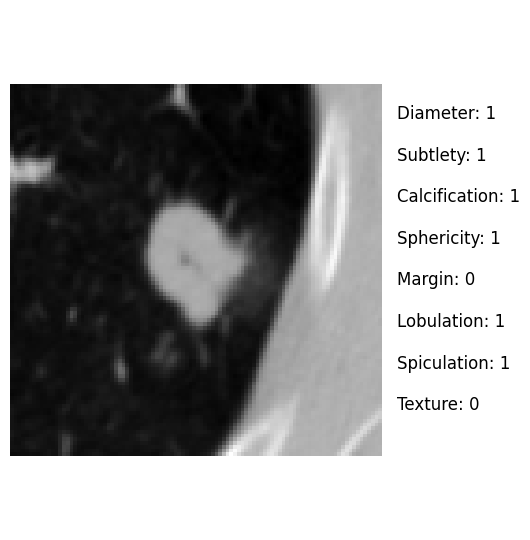

Image Shape: (100, 100), Image Type: int16
8


In [413]:
# Load data
all_labels = pd.read_csv("./dataset/2D/Meta/slice_labels.csv")

# Assuming transformations have been applied as in previous examples
# Here, we'll simulate that step:
# all_labels['Subtlety'] = all_labels['Subtlety'].replace({1: 1, 2: 1, 3: 1, 4: 2, 5: 2})
# all_labels.drop(columns=['Internalstructure'], inplace=True)
# all_labels['Calcification'] = all_labels['Calcification'].replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2})
# all_labels['Sphericity'] = all_labels['Sphericity'].replace({1: 1, 2: 1, 3: 1, 4: 2, 5: 2})
# all_labels['Margin'] = all_labels['Margin'].replace({1: 1, 2: 1, 3: 1, 4: 2, 5: 2})
# all_labels['Lobulation'] = all_labels['Lobulation'].replace({1: 1, 2: 2, 3: 2, 4: 2, 5: 2})
# all_labels['Spiculation'] = all_labels['Spiculation'].replace({1: 1, 2: 2, 3: 2, 4: 2, 5: 2})
# all_labels['Texture'] = all_labels['Texture'].replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 2})
# all_labels['Diameter'] = all_labels['Diameter'].replace({1: 1, 2: 1, 3: 2, 4: 2, 5: 2})
# all_labels['Malignancy'] = all_labels['Malignancy'].replace({1: 1, 2: 1, 3: 2, 4: 3, 5: 3})

# Preprocess the labels
indeterminate = False
all_labels['Subtlety'] = all_labels['Subtlety'].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})
all_labels.drop(columns=['Internalstructure'], inplace=True)
all_labels['Calcification'] = all_labels['Calcification'].replace({1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1})
all_labels['Sphericity'] = all_labels['Sphericity'].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})
all_labels['Margin'] = all_labels['Margin'].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})
all_labels['Lobulation'] = all_labels['Lobulation'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1})
all_labels['Spiculation'] = all_labels['Spiculation'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1})
all_labels['Texture'] = all_labels['Texture'].replace({1: 0, 2: 0, 3: 0, 4: 0, 5: 1})
all_labels['Diameter'] = all_labels['Diameter'].replace({1: 0, 2: 0, 3: 1, 4: 1, 5: 1})
if indeterminate:
    all_labels['Malignancy'] = all_labels['Malignancy'].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})
else:
    all_labels['Malignancy'] = all_labels['Malignancy'].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})
    
image_path = all_labels['image_dir']
characteristics = all_labels[all_labels.columns[1:-1]]
malignancy = all_labels[['Malignancy']]

num_characteristics = len(characteristics.columns)

class_counts = characteristics.apply(pd.Series.value_counts)
char_weights = class_counts.apply(lambda x: (x.mean()) / x)

class_counts = malignancy.apply(pd.Series.value_counts)
malignancy_weights = class_counts.apply(lambda x: (x.mean()) / x)

nodule = 10
img = np.load(image_dir[nodule])
# img = Image.fromarray(img)
feature_data = characteristics.iloc[nodule]

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 5.5), gridspec_kw={'width_ratios': [5, 1]})

# Plot the image on the left subplot
ax1.imshow(img, cmap='gray')
ax1.axis('off')  # Hide axes for image

# Display the feature data on the right subplot
ax2.axis('off')  # No need for axes on the right subplot
features_text = "\n\n".join([f"{key}: {val}" for key, val in feature_data.items() if key != 'image_dir'])
ax2.text(0.01, 0.52, features_text, transform=ax2.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='left')

plt.tight_layout()
plt.show()

print(f"Image Shape: {img.shape}, Image Type: {img.dtype}")
print(num_characteristics)

In [414]:
# Extract patient identifiers from the image directory paths
all_labels['patient_id'] = all_labels['image_dir'].apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x))+'-'+os.path.basename(os.path.dirname(x))))
grouped_labels = all_labels.groupby('patient_id')
group_keys = list(grouped_labels.groups.keys())

In [424]:
len(grouped_labels)

1380

In [430]:
group_key = group_keys[20]
nodule_data = grouped_labels.get_group(group_key)
nodule_data

,image_dir,Diameter,Subtlety,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,patient_id
193,./dataset/2D/slices/LIDC-IDRI-0012/NODULE-6/SL...,0,1,1,1,1,0,0,1,0,LIDC-IDRI-0012-NODULE-6
194,./dataset/2D/slices/LIDC-IDRI-0012/NODULE-6/SL...,0,1,1,1,1,0,0,1,0,LIDC-IDRI-0012-NODULE-6
195,./dataset/2D/slices/LIDC-IDRI-0012/NODULE-6/SL...,0,1,1,1,1,0,0,1,0,LIDC-IDRI-0012-NODULE-6
196,./dataset/2D/slices/LIDC-IDRI-0012/NODULE-6/SL...,0,1,1,1,1,0,0,1,0,LIDC-IDRI-0012-NODULE-6


In [436]:
labels = nodule_data.iloc[0][['Diameter', 'Subtlety', 'Calcification', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']].values
print(labels[-1])
final_pred_label = nodule_data.iloc[0][['Malignancy']
print(final_pred_label)

0


AttributeError: 'numpy.int64' object has no attribute 'values'

Images Shape: (4, 100, 100), Images Type: int16


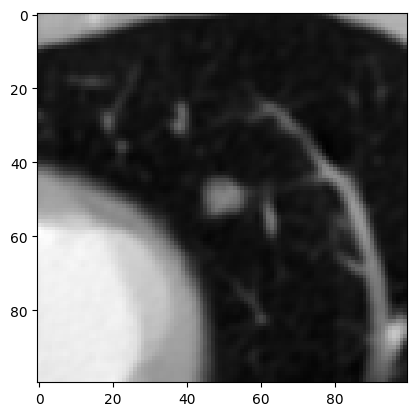

In [440]:
images = [np.load(image_dir) for image_dir in nodule_data['image_dir']]
images = np.stack(images)
print(f"Images Shape: {images.shape}, Images Type: {images.dtype}")
# Plot first image
plt.imshow(images[3], cmap='gray')